# Total RMSE for performance assessment of ARPEGE-Climat PPE

<a id="top">This code</a> is combining the metric of four different variables (tas, pr, SW, LW) to create an aggretated metric $E_{tot}$ used for performance assessment and seleciton of an optimal sub-set of parametrizations. 

### [Step 1 - Emulator skill evaluation](#skill)
### [Figure histograms](#histograms)
### [Step 2 - Initial guess for optimization 1 ](#init1)
### [Step 3 - Optimisation 1 ](#optim1)
### [Step 4 - Initial guess for Optimization 2 (param. smoothing)](#init2)
### [Step 5 - Optimisation 2](#optim2)
### [Step 6 - Optimal subset of parameters](#selection)
### [Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3](#validation)
### [Step 8  - Feedback likelihood](#likelihood)
### [Step 9  - Parameter analysis](#param)

## Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

## Functions

In [2]:
N_error = 128*256

In [3]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

# FONCTION MOYENNE NORMALISEE DES VARIABLES

def Norm_Average_df(Fdbck, variables, E_p1_df, name) :

    E_df = pd.DataFrame()
    E_df['Fdbck'] = Fdbck

    tmp = [0]*len(E_df) 

    for i in variables :
        E = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'+name+'_'+i+'.npy')
        E_df['RMSE_'+i] = E

        E_df['RMSE_'+i+'_norm'] = E_df['RMSE_'+i]/E_p1_df['E_p1_'+i]

        tmp = tmp + E_df['RMSE_'+i+'_norm']
    
    E_df['RMSE_total'] = tmp/len(variables)
    return E_df

In [4]:
def MultiLinReg_RMSE_skill_eval(limit_train, x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def function_RMSE_emulator_std_skill_eval(limit_train, x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_RMSE_skill_eval(limit_train,x, 1, variable)
    pc2 = MultiLinReg_RMSE_skill_eval(limit_train,x, 2, variable)
    pc3 = MultiLinReg_RMSE_skill_eval(limit_train,x, 3, variable)
    pc4 = MultiLinReg_RMSE_skill_eval(limit_train,x, 4, variable)
    pc5 = MultiLinReg_RMSE_skill_eval(limit_train,x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_total_skill_eval(limit_train, x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator_std_skill_eval(limit_train, x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E

In [5]:
# FONCTIONS FEEDBACKS

def em_fdb_std_skill_eval(limit_train, x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [6]:
# FUNCTIONS EMULATORS

def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

# FONCTIONS ERROR

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable =='tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

def function_RMSE_total(x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator(x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E
    

In [7]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1_'+variable+'.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2_'+variable+'.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3_'+variable+'.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4_'+variable+'.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5_'+variable+'.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1_'+variable+'.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2_'+variable+'.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3_'+variable+'.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4_'+variable+'.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5_'+variable+'.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(N_error)
    
    jac = (A/B)*D
    
    return jac

# FONCTION JACOBIAN OF TOTAL ERROR

def jacobian_total(x, variables, E_p1_df) :
    
    tmp = 0
    for i in variables : 
        tmp0 = jacobian(x, i)/E_p1_df['E_p1_'+i]
        tmp = tmp + tmp0
    
    jac = tmp/len(variables)
    
    return jac

In [8]:
# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [9]:

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variables, E_p1_df) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_total(x0, variables, E_p1_df)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_total,  x0, args=(variables, E_p1_df), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian_total, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_total(sol.x, variables, E_p1_df)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [10]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

## Settings

In [11]:
variables = ['tas', 'pr', 'SW', 'LW']

variable_plot = 'total'
TITLE = 'Total'
ylabel = '$E_{tot}$ (no units)'

product = 'BEST'

## Get the data

### p1 default

In [12]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df = {}

for i in variables :
    E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+i+'.npy')
    E_p1_df['E_p1_'+i] = E_p1

E_p1_df

{'E_p1_tas': array(0.6682929),
 'E_p1_pr': array(0.5400475),
 'E_p1_SW': array(6.54059149),
 'E_p1_LW': array(3.45993611)}

In [13]:
p1_feedbacks

array(-1.3328964)

In [14]:
E_p1_tmp = E_p1_df['E_p1_tas']/E_p1_df['E_p1_tas'] + E_p1_df['E_p1_pr']/E_p1_df['E_p1_pr'] + E_p1_df['E_p1_SW']/E_p1_df['E_p1_SW']+E_p1_df['E_p1_LW']/E_p1_df['E_p1_LW']
E_p1 = E_p1_tmp/4
E_p1

1.0

### CFMIP

In [15]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [16]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

MRI = {}
CAN = {}
MIROC = {}
HadGEM3 = {}
IPSL = {}
BCC = {}

for i in variables :
    
    #if i == 'tas' :
    #    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'_'+product+'.npy')
    #else :
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'.npy')
    
    filename = 'U_MRI_'+i+'.npy'
    MRI[i] = Error(path, filename, U_obs)

    filename = 'U_CAN_'+i+'.npy'
    CAN[i] = Error(path, filename, U_obs)

    filename = 'U_MIROC_'+i+'.npy'
    MIROC[i] = Error(path, filename, U_obs)

    filename = 'U_HadGEM3_'+i+'.npy'
    HadGEM3[i] = Error(path, filename, U_obs)

    filename = 'U_IPSL_'+i+'.npy'
    IPSL[i] = Error(path, filename, U_obs)

    filename = 'U_BCC_'+i+'.npy'
    BCC[i] = Error(path, filename, U_obs)
    

E_MRI_tmp = MRI['tas']/E_p1_df['E_p1_tas'] + MRI['pr']/E_p1_df['E_p1_pr'] + MRI['SW']/E_p1_df['E_p1_SW']+MRI['LW']/E_p1_df['E_p1_LW']
E_MRI = E_MRI_tmp/4

E_CAN_tmp = CAN['tas']/E_p1_df['E_p1_tas'] + CAN['pr']/E_p1_df['E_p1_pr'] + CAN['SW']/E_p1_df['E_p1_SW']+CAN['LW']/E_p1_df['E_p1_LW']
E_CAN = E_CAN_tmp/4

E_MIROC_tmp = MIROC['tas']/E_p1_df['E_p1_tas'] + MIROC['pr']/E_p1_df['E_p1_pr'] + MIROC['SW']/E_p1_df['E_p1_SW']+MIROC['LW']/E_p1_df['E_p1_LW']
E_MIROC = E_MIROC_tmp/4

E_HadGEM3_tmp = HadGEM3['tas']/E_p1_df['E_p1_tas'] + HadGEM3['pr']/E_p1_df['E_p1_pr'] + HadGEM3['SW']/E_p1_df['E_p1_SW']+HadGEM3['LW']/E_p1_df['E_p1_LW']
E_HadGEM3 = E_HadGEM3_tmp/4

E_IPSL_tmp = IPSL['tas']/E_p1_df['E_p1_tas'] + IPSL['pr']/E_p1_df['E_p1_pr'] + IPSL['SW']/E_p1_df['E_p1_SW']+IPSL['LW']/E_p1_df['E_p1_LW']
E_IPSL = E_IPSL_tmp/4

E_BCC_tmp = BCC['tas']/E_p1_df['E_p1_tas'] + BCC['pr']/E_p1_df['E_p1_pr'] + BCC['SW']/E_p1_df['E_p1_SW']+BCC['LW']/E_p1_df['E_p1_LW']
E_BCC = E_BCC_tmp/4

In [17]:
MIROC

{'tas': 1.9379747457002985,
 'pr': 0.6142294967526306,
 'SW': 11.838976503373102,
 'LW': 8.385906097815127}

In [18]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

### PPE

In [19]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

name = 'RMSE_PPE'
E_PPE_df = Norm_Average_df(Fdbck_PPE, variables, E_p1_df, name) 
E_PPE_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-0.825236,0.517115,0.773785,1.327665,2.458423,22.190244,3.392697,6.809218,1.968019,2.148231
1,-1.659636,1.001088,1.497979,1.119965,2.073827,10.055562,1.537409,7.093494,2.050181,1.789849
2,-1.215000,1.219696,1.825092,1.131642,2.095448,7.014416,1.072444,10.118338,2.924429,1.979353
3,-1.321641,0.975016,1.458965,1.485628,2.750921,11.116918,1.699681,8.833412,2.553056,2.115656
4,-0.750397,0.823381,1.232065,0.947449,1.754380,11.843062,1.810702,6.255715,1.808044,1.651298
...,...,...,...,...,...,...,...,...,...,...
97,-1.516367,1.210617,1.811507,1.312706,2.430724,11.950042,1.827058,6.534499,1.888618,1.989477
98,-1.584491,1.058532,1.583935,0.641261,1.187415,7.461267,1.140763,6.364555,1.839501,1.437904
99,-1.474525,0.889521,1.331034,0.787310,1.457854,7.351283,1.123948,5.239393,1.514303,1.356785
100,-1.445422,1.414495,2.116580,0.788963,1.460914,10.676445,1.632336,6.683621,1.931718,1.785387


In [20]:
E_PPE = E_PPE_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable_plot+'.npy', E_PPE)

### Multi Lin Reg predictions

In [34]:
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
name = 'RMSE_multilinreg_pred'

E_multilinreg_df = Norm_Average_df(Fdbck_multilinreg_pred, variables, E_p1_df, name) 
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.499698,0.639924,0.957551,0.934483,1.730371,3.447441,0.527084,4.496589,1.299616,1.128656
1,-1.339351,0.632299,0.946141,0.873935,1.618257,9.271144,1.417478,5.598323,1.618042,1.399980
2,-1.323732,0.778552,1.164986,1.006775,1.864233,10.843600,1.657893,5.905107,1.706710,1.598455
3,-1.541909,1.127637,1.687340,1.171886,2.169969,7.735416,1.182678,9.310045,2.690814,1.932700
4,-1.346961,0.496335,0.742691,1.015541,1.880466,7.811751,1.194349,4.844026,1.400033,1.304385
...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,0.748789,1.120450,0.880405,1.630236,11.670598,1.784334,6.327942,1.828919,1.590985
99996,-1.410350,1.031171,1.542993,1.137027,2.105420,12.883463,1.969770,5.864764,1.695050,1.828308
99997,-1.296397,0.752894,1.126593,0.832480,1.541494,10.345091,1.581675,5.497670,1.588951,1.459678
99998,-1.299809,1.163394,1.740845,0.659606,1.221385,12.062119,1.844194,4.468051,1.291368,1.524448


In [35]:
E_multilinreg = E_multilinreg_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable_plot+'.npy', E_multilinreg)

### [Back to the top](#top)

# <a id="skill">Step 1 - Emulator skill evaluation</a> </li>

In [23]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

RMSE_skill_eval = []
for i in X :
    tmp = function_RMSE_total_skill_eval(80, i, variables, E_p1_df)
    RMSE_skill_eval.append(tmp)

Validation_RMSE_df = pd.DataFrame()
Validation_RMSE_df['RMSE_PPE_total'] = E_PPE_df['RMSE_total']
Validation_RMSE_df['RMSE_multilinreg_val_total'] = RMSE_skill_eval
Validation_RMSE_df

,RMSE_PPE_total,RMSE_multilinreg_val_total
0,2.148231,1.599713
1,1.789849,1.728810
2,1.979353,2.078335
3,2.115656,1.978998
4,1.651298,1.630934
...,...,...
97,1.989477,1.821666
98,1.437904,1.607730
99,1.356785,1.385697
100,1.785387,1.788970


In [24]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_multilinreg_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_Etot = sqrt(sum_diff/n)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_Etot)
OSE_Etot

0.23418510976291992

In [25]:
r_test = np.corrcoef(Test_set['RMSE_multilinreg_val_total'], Test_set['RMSE_PPE_total'])
r_test

array([[1.        , 0.75966632],
       [0.75966632, 1.        ]])

In [26]:
r_full = np.corrcoef(Validation_RMSE_df['RMSE_multilinreg_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_full

array([[1.        , 0.85174532],
       [0.85174532, 1.        ]])

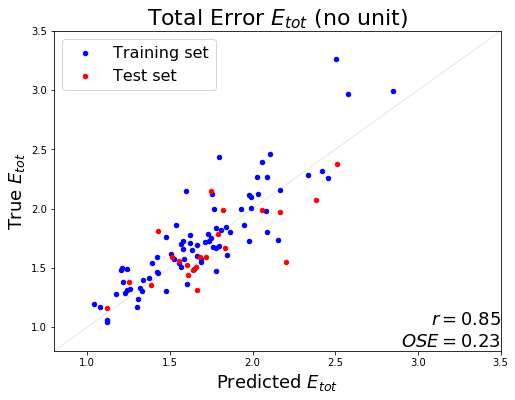

In [27]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"
Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.23$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.85$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.8,3.5)
plt.xlim(0.8,3.5)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [28]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

Fdbck_skill_eval = []
for i in X :
    tmp = em_fdb_std_skill_eval(80, i)
    Fdbck_skill_eval.append(tmp)

Validation_fdbck_df = pd.DataFrame()
Validation_fdbck_df['Fdbck_PPE'] = E_PPE_df['Fdbck']
Validation_fdbck_df['Fdbck_multilinreg_val'] = Fdbck_skill_eval
Validation_fdbck_df

,Fdbck_PPE,Fdbck_multilinreg_val
0,-0.825236,-1.180536
1,-1.659636,-1.594507
2,-1.215000,-1.068508
3,-1.321641,-1.363567
4,-0.750397,-1.140111
...,...,...
97,-1.516367,-1.550227
98,-1.584491,-1.635200
99,-1.474525,-1.418686
100,-1.445422,-1.621942


In [29]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_multilinreg_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_fdbck = sqrt(sum_diff/n)
OSE_fdbck

0.18506045695913942

In [30]:
r_test = np.corrcoef(Test_set_fdbck['Fdbck_multilinreg_val'], Test_set_fdbck['Fdbck_PPE'])
r_test

array([[1.        , 0.48017716],
       [0.48017716, 1.        ]])

In [31]:
r_full = np.corrcoef(Validation_fdbck_df['Fdbck_multilinreg_val'], Validation_fdbck_df['Fdbck_PPE'])
r_full

array([[1.       , 0.7259311],
       [0.7259311, 1.       ]])

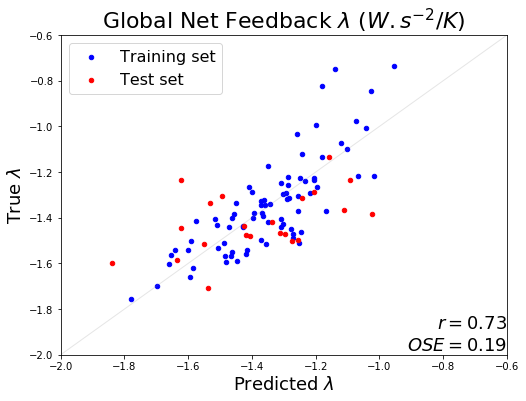

In [32]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.73$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.6)
plt.xlim(-2.0,-0.6)
ax.plot((-2.0,-0.6), (-2.0,-0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [10]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable_plot+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [11]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable_plot+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [12]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.103096,0.773586
1,-1.064409,0.992775
2,-1.029369,0.983609
3,-1.276465,0.900185
4,-1.198514,0.840486
...,...,...
1168,-1.239931,0.888797
1169,-1.320968,0.929936
1170,-1.248014,0.852261
1171,-1.432138,0.989746


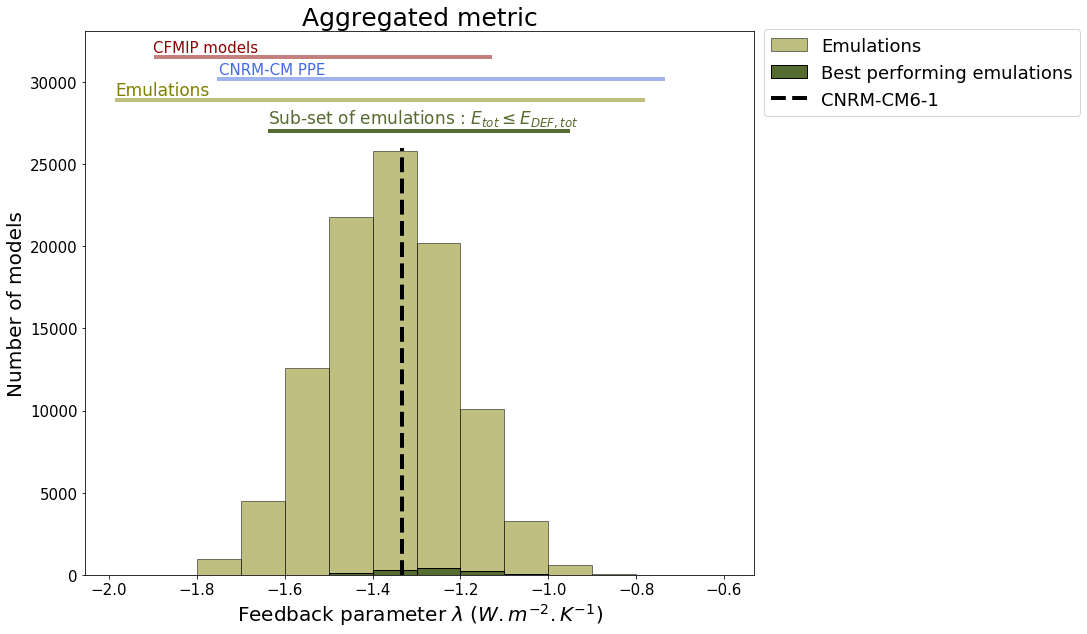

In [13]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{tot}\leq E_{DEF,tot}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [16]:
pourc = 100*len(MLR_short)/len(Fdbck_MLR)
pourc

1.173

In [42]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable_plot+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [43]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


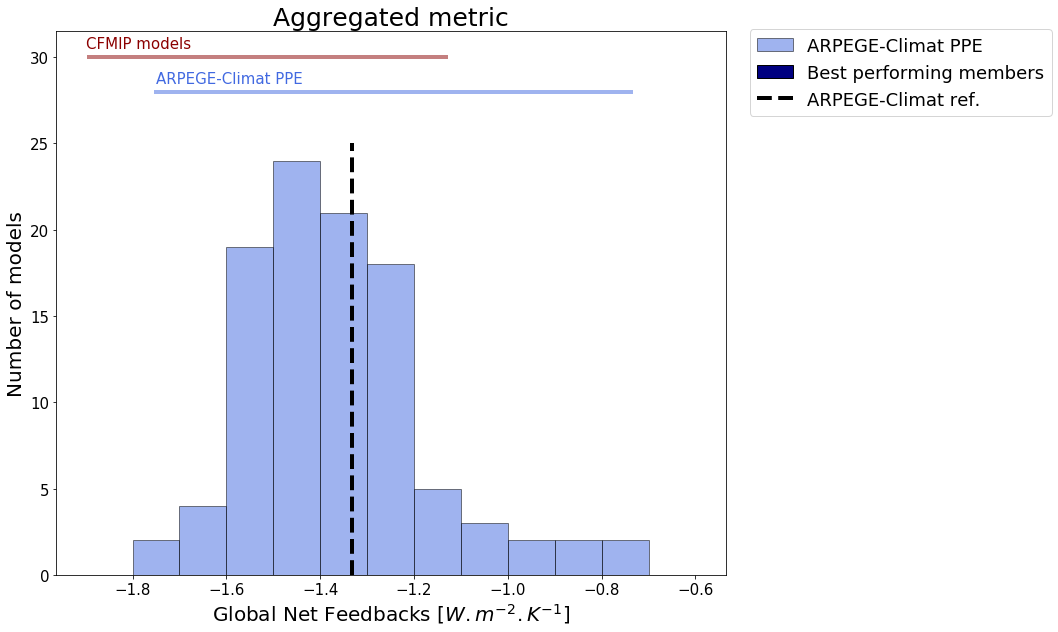

In [44]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'ARPEGE-Climat PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
#plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tot}\leq E_{DEF,tot}$', 
#         color = 'navy', fontsize=17)

legend=['ARPEGE-Climat PPE', 'Best performing members', 'ARPEGE-Climat ref.']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="init1">Step 2 - Initial guess for optimization 1</a> </li> 

In [65]:
E_multilinreg_df['Fdbck_round'] = E_multilinreg_df['Fdbck'].round(decimals=2)
E_multilinreg_df = E_multilinreg_df.set_index('Fdbck_round')
E_multilinreg_df['members'] = range(0,100000,1) 
E_multilinreg_df        

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,members
Fdbck_round,,,,,,,,,,,
-1.50,-1.499698,0.639924,0.957551,0.934483,1.730371,3.447441,0.527084,4.496589,1.299616,1.128656,0
-1.34,-1.339351,0.632299,0.946141,0.873935,1.618257,9.271144,1.417478,5.598323,1.618042,1.399980,1
-1.32,-1.323732,0.778552,1.164986,1.006775,1.864233,10.843600,1.657893,5.905107,1.706710,1.598455,2
-1.54,-1.541909,1.127637,1.687340,1.171886,2.169969,7.735416,1.182678,9.310045,2.690814,1.932700,3
-1.35,-1.346961,0.496335,0.742691,1.015541,1.880466,7.811751,1.194349,4.844026,1.400033,1.304385,4
...,...,...,...,...,...,...,...,...,...,...,...
-1.45,-1.453679,0.748789,1.120450,0.880405,1.630236,11.670598,1.784334,6.327942,1.828919,1.590985,99995
-1.41,-1.410350,1.031171,1.542993,1.137027,2.105420,12.883463,1.969770,5.864764,1.695050,1.828308,99996
-1.30,-1.296397,0.752894,1.126593,0.832480,1.541494,10.345091,1.581675,5.497670,1.588951,1.459678,99997


In [66]:
new_df=pd.DataFrame()
new_df['RMSE_total_best'] = E_multilinreg_df['RMSE_total'].groupby('Fdbck_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_round,RMSE_total_best
0,-1.99,1.995323
1,-1.95,2.231187
2,-1.93,2.604674
3,-1.91,3.010443
4,-1.90,1.890005
...,...,...
108,-0.86,1.514971
109,-0.85,1.822656
110,-0.82,2.623985
111,-0.80,2.483398


In [67]:
list_RMSE = new_df['RMSE_total_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_df['RMSE_total'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_df['Fdbck'].iloc[cpt])
            tmp_member.append(E_multilinreg_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_round,RMSE_total_best,Fdbck,members
0,-1.99,1.995323,-1.985956,35649
1,-1.95,2.231187,-1.953341,47523
2,-1.93,2.604674,-1.927200,30599
3,-1.91,3.010443,-1.914973,74150
4,-1.90,1.890005,-1.901409,94179
...,...,...,...,...
108,-0.86,1.514971,-0.860371,58900
109,-0.85,1.822656,-0.850213,95065
110,-0.82,2.623985,-0.820649,57260
111,-0.80,2.483398,-0.803475,76973


In [68]:
# CHECK OBJECTIVE FUNCTION

#x = x_best[4]
#y = function_RMSE_total(x, variables, E_p1_df)
#print(y)

### [Back to the top](#top)

# <a id="optim1">Step 3 - Optimization 1</a> </li> 

In [49]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [50]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [51]:
sol_df = Optimization(x_best, 0.0001, xlim, variables, E_p1_df)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.842874101212437
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4256076713537467
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0814518759881735
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1992974776553975
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6186851517376313
            Iterations: 3
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8931173829465189
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9930040328679505
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8421687131061302
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9182630741965208
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9140013853791515
            Iterations: 3
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.764556464619804
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7507593278896075
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8008175118308813
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7742399677828901
            Iterations: 2
            Function evaluations: 15
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7143535390729586
            Iterations: 3
            Function evaluati

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.842874,-1.985856,0.060000,0.854146,2.222555,29.806659,-0.034039,8.798378,3.042451,0.000505,...,-2.490277,-25.288171,0.040703,13.874951,0.000010,0.912314,0.636407,0.500000,0.500000,6.087890
1,1.425608,-1.953241,0.060000,0.500000,2.023924,18.661248,-0.010000,6.973089,5.557106,0.000500,...,-2.382700,-30.614742,0.030384,17.065284,0.000010,0.921604,0.619132,0.500000,0.500000,3.099319
2,2.081452,-1.927100,0.060000,0.500000,0.887830,26.985975,-0.010000,7.505058,1.636404,0.000500,...,-1.650361,-49.402842,0.061406,8.608188,0.000010,0.895785,0.784088,0.694211,0.500000,7.036454
3,2.199297,-1.914873,0.060000,0.515740,2.036125,18.289178,-0.179049,8.647269,0.519142,0.000500,...,-1.726973,-40.569974,0.041855,1.699519,0.000010,0.890979,0.757296,0.503004,0.500000,1.347986
4,1.618685,-1.901309,0.060000,0.500000,1.689607,20.355442,-0.091148,9.001173,0.250998,0.000500,...,-2.643068,-31.119862,0.022211,18.036791,0.000010,0.894005,0.620771,0.500000,0.500000,8.035030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.284897,-0.860271,0.060000,2.416445,1.866155,5.448568,-0.354056,2.722947,5.050882,0.000500,...,-1.417053,-44.297029,0.010000,7.478987,0.000100,0.676532,0.649159,0.790977,0.711971,9.750403
109,1.444417,-0.850313,0.060032,2.206733,1.158562,10.376906,-0.286141,1.375354,5.913115,0.010000,...,-1.889592,-47.110335,0.010000,1.887449,0.000100,0.619179,0.710836,0.691957,0.668653,2.785310
110,1.689886,-0.820749,0.060000,2.496228,0.585579,17.669677,-0.426389,0.398208,4.381717,0.010000,...,-1.143142,-25.748471,0.010000,1.275362,0.000100,0.692064,0.500000,0.960019,0.742678,1.620904
111,2.173378,-0.803575,0.066068,2.264101,1.679428,21.212615,-0.136489,0.303354,4.019815,0.010000,...,-2.824158,-44.670111,0.010000,5.085701,0.000100,0.897086,0.850079,0.584722,0.792831,1.306760


### Plotting

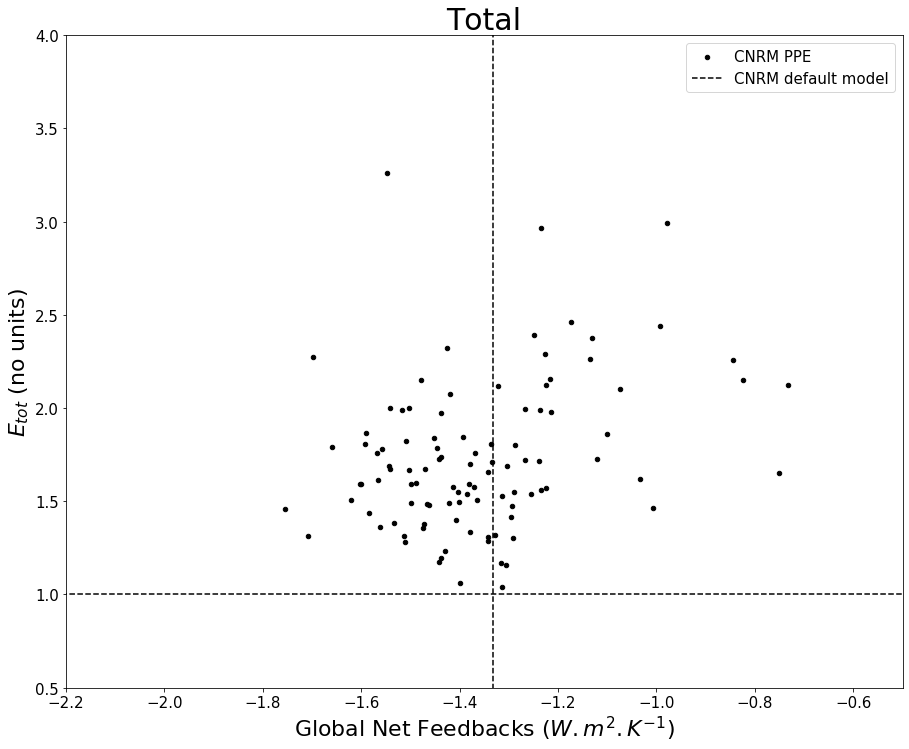

In [55]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_only.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

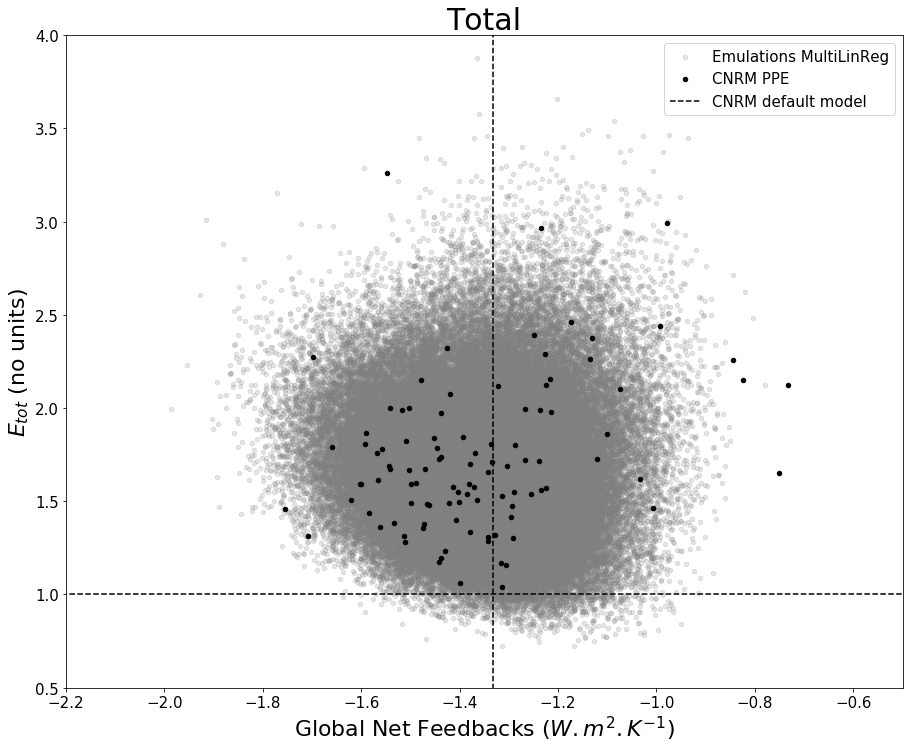

In [56]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

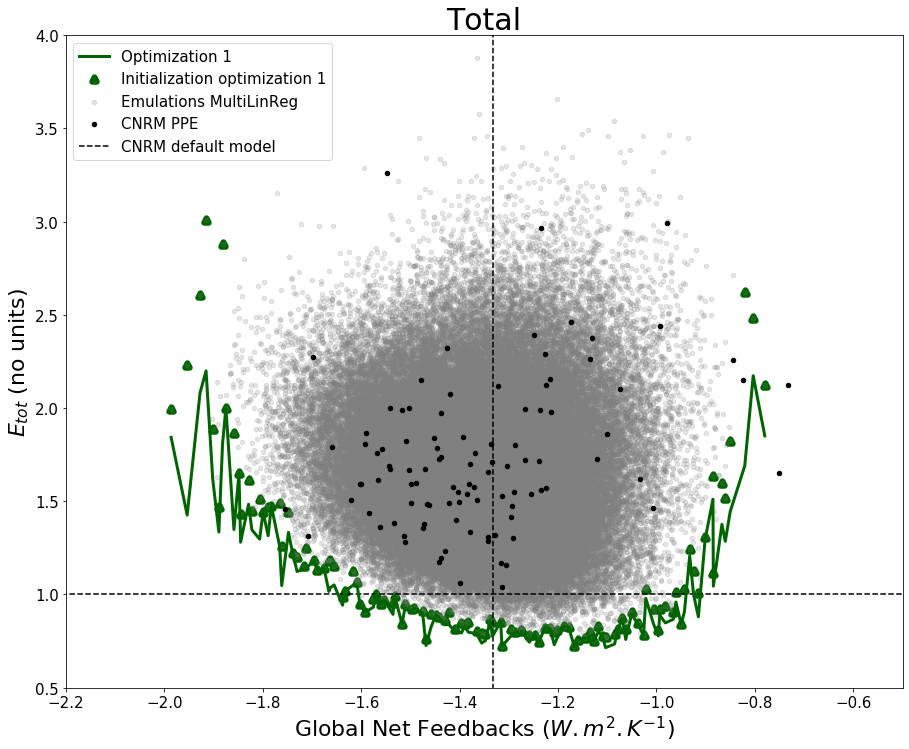

In [57]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

#  <a id="init2">Step 4 - Initial guess for Optimization 2 (param. smoothing)</a> </li> 

In [58]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.060000,0.854146,2.222555,29.806659,-0.034039,8.798378,3.042451,0.000505,0.001000,...,-2.490277,-25.288171,0.040703,13.874951,0.000010,0.912314,0.636407,0.500000,0.500000,6.087890
1,-1.953241,0.060000,0.588536,1.789558,23.528782,-0.016010,7.562403,3.948267,0.000501,0.001000,...,-2.525927,-26.007587,0.042310,13.736729,0.000012,0.908064,0.645408,0.510124,0.506157,5.929115
2,-1.927100,0.060000,0.503935,1.458928,22.730594,-0.052262,7.657618,2.337264,0.000500,0.001000,...,-2.561162,-26.715481,0.043900,13.598891,0.000015,0.903919,0.654356,0.520240,0.512310,5.773165
3,-1.914873,0.060000,0.507870,1.662422,20.979943,-0.114812,8.450192,0.731421,0.000500,0.001000,...,-2.595573,-27.401011,0.045459,13.461753,0.000017,0.899977,0.663195,0.530339,0.518454,5.622748
4,-1.901309,0.061320,0.587441,1.513731,18.887439,-0.104864,8.991376,2.468732,0.000875,0.000987,...,-2.628760,-28.054637,0.046972,13.325503,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.860271,0.095444,2.279281,1.559950,8.870264,-0.360325,2.492813,5.756966,0.004426,0.000077,...,-2.566210,-45.060507,0.014911,7.091961,0.000068,0.590518,0.589905,0.876520,0.815990,6.612444
109,-0.850313,0.060016,2.331535,1.192214,10.968014,-0.338182,1.467966,5.314708,0.007625,0.000050,...,-2.551903,-45.616317,0.014830,7.633703,0.000068,0.580514,0.577845,0.896972,0.824512,6.895640
110,-0.820749,0.061525,2.365822,1.002287,16.732219,-0.318852,0.618781,4.674091,0.010000,0.000050,...,-2.536447,-46.192130,0.014758,8.193539,0.000068,0.570003,0.565471,0.918185,0.833459,7.187238
111,-0.803575,0.094671,2.408848,1.269522,22.373369,-0.278025,0.704415,4.668332,0.008798,0.000148,...,-2.520183,-46.782052,0.014692,8.765781,0.000067,0.559138,0.552879,0.939918,0.842701,7.484548


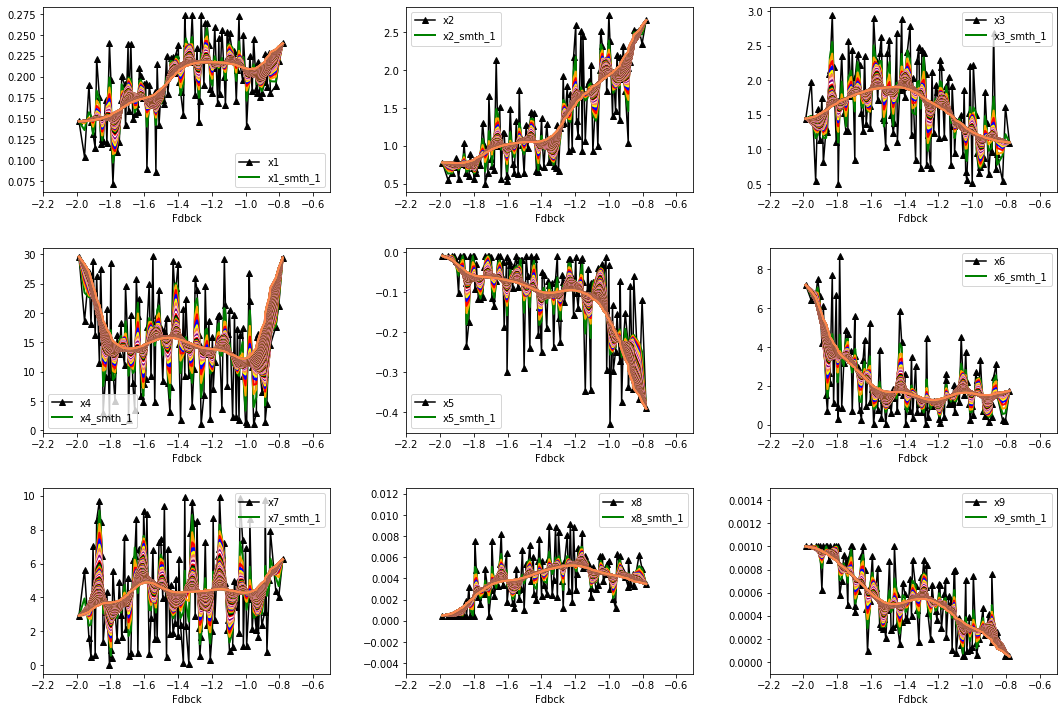

In [83]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

# <a id="optim2">Step 5 - Optimisation 2</a> </li> 

In [59]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.06      , 0.85414571, 2.22255526, ..., 0.5       , 0.5       ,
        6.08789044],
       [0.06231439, 0.84136186, 2.18800845, ..., 0.51012355, 0.50615706,
        5.92911466],
       [0.0646265 , 0.82890444, 2.15388118, ..., 0.52023983, 0.51231009,
        5.77316496],
       ...,
       [0.17934672, 2.49167194, 1.2025723 , ..., 0.91818486, 0.833459  ,
        7.18723806],
       [0.18290603, 2.55105602, 1.16825524, ..., 0.93991778, 0.84270094,
        7.48454843],
       [0.18654541, 2.61096085, 1.13365303, ..., 0.9619143 , 0.85209425,
        7.78474916]])

In [60]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_total(i, variables, E_p1_df)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,1.842874
1,-1.953241,1.794838
2,-1.927100,1.747493
3,-1.914873,1.701058
4,-1.901309,1.655734
...,...,...
108,-0.860271,1.458917
109,-0.850313,1.549799
110,-0.820749,1.645961
111,-0.803575,1.746647


In [61]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variables, E_p1_df)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.776953217269983
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7629601870736908
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7474764767891677
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7010601422209175
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6557345108124317
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8609011211923439
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8511716427467817
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8416521829562233
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8323318724763566
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8232055333384267
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.692162229690396
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6923425779714851
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6928384096287398
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6936947750233042
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6949702340896193
            Iterations: 1
            Function evaluati

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.762960,-1.971606,0.060000,0.771711,2.109585,28.387070,-0.010000,8.517878,3.179734,0.000500,...,-2.506757,-25.984719,0.042037,13.524081,0.000010,0.909729,0.629001,0.500000,0.500000,5.884610
2,1.747476,-1.957607,0.064617,0.828770,2.153730,27.047637,-0.044442,8.500317,3.359057,0.000905,...,-2.561124,-26.715433,0.043889,13.598473,0.000015,0.903923,0.654323,0.520200,0.512286,5.773078
3,1.701060,-1.943609,0.066933,0.817078,2.120559,25.715006,-0.049635,8.352687,3.511770,0.001104,...,-2.595572,-27.401009,0.045458,13.461733,0.000017,0.899978,0.663194,0.530337,0.518452,5.622744
4,1.655735,-1.929758,0.069233,0.806180,2.088401,24.436898,-0.054642,8.205983,3.657854,0.001300,...,-2.628760,-28.054637,0.046972,13.325501,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.455842,-0.834215,0.157016,2.346720,1.264706,23.537382,-0.364038,1.787752,5.313115,0.005856,...,-2.563512,-45.052371,0.014225,7.069913,0.000073,0.596186,0.587515,0.871901,0.797610,6.606023
109,1.448764,-0.820870,0.119989,2.328477,1.221399,24.918576,-0.359082,1.792622,5.529209,0.007510,...,-2.542609,-45.587788,0.012499,7.554453,0.000084,0.600643,0.569731,0.880656,0.760203,6.873109
110,1.618494,-0.807407,0.060000,2.270250,1.173089,26.355960,-0.346376,1.799802,5.749377,0.010000,...,-2.517253,-46.132130,0.010000,8.023230,0.000100,0.612746,0.548887,0.883723,0.698772,7.139820
111,1.701626,-0.793798,0.060000,2.325438,1.140221,27.850900,-0.357062,1.806978,5.987342,0.010000,...,-2.501056,-46.721158,0.010000,8.589710,0.000100,0.602930,0.536530,0.904800,0.706588,7.436392


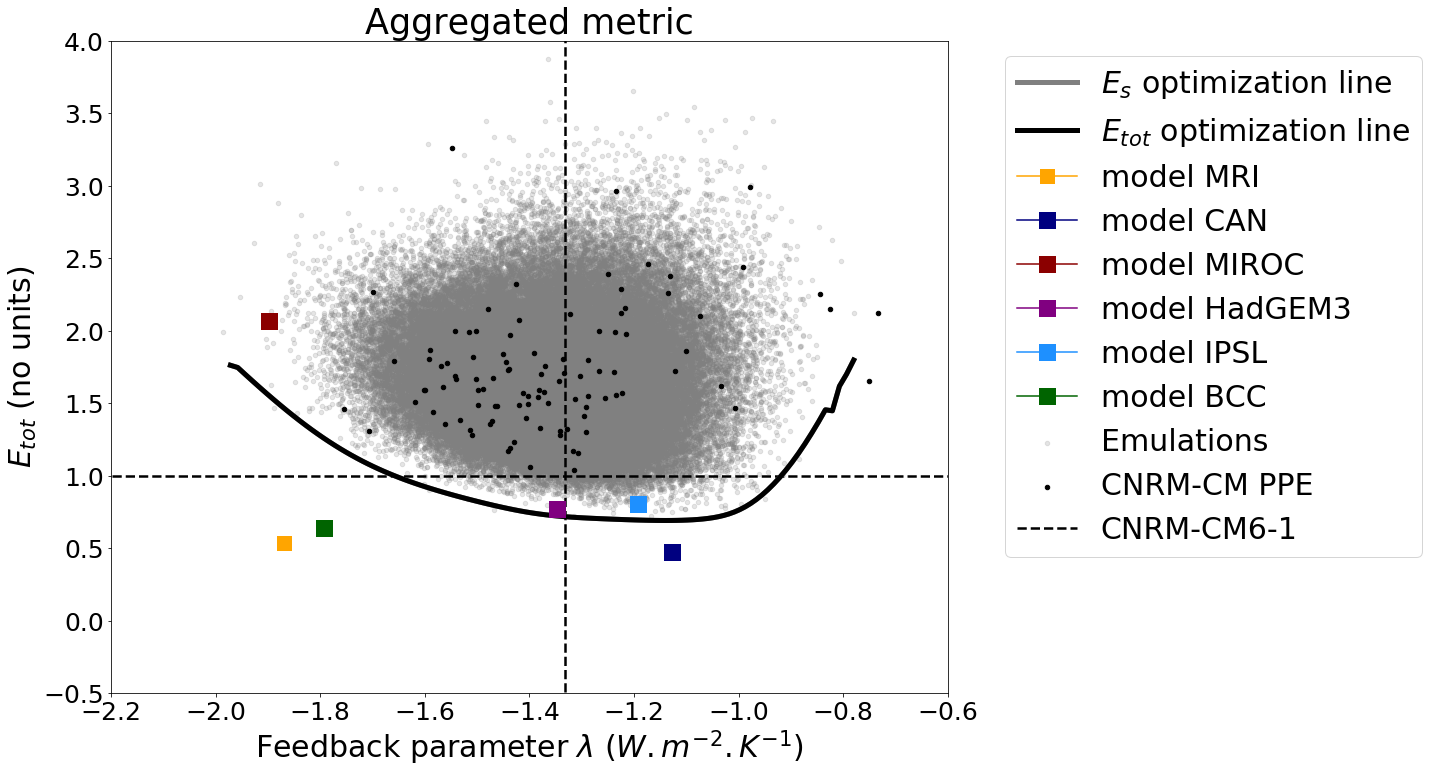

In [75]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{s}$ optimization line', '$E_{tot}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=30, bbox_to_anchor=(1.05, 1))

plt.title('Aggregated metric', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,4.0)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [76]:
RMSE_optim2 = sol_df_2#['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable_plot+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable_plot+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

In [15]:
df_select = sol_df_2[sol_df_2.index % 15 == 0]
df_select = df_select.append(sol_df_2.iloc[len(sol_df_2)-1])
df_select

NameError: name 'sol_df_2' is not defined

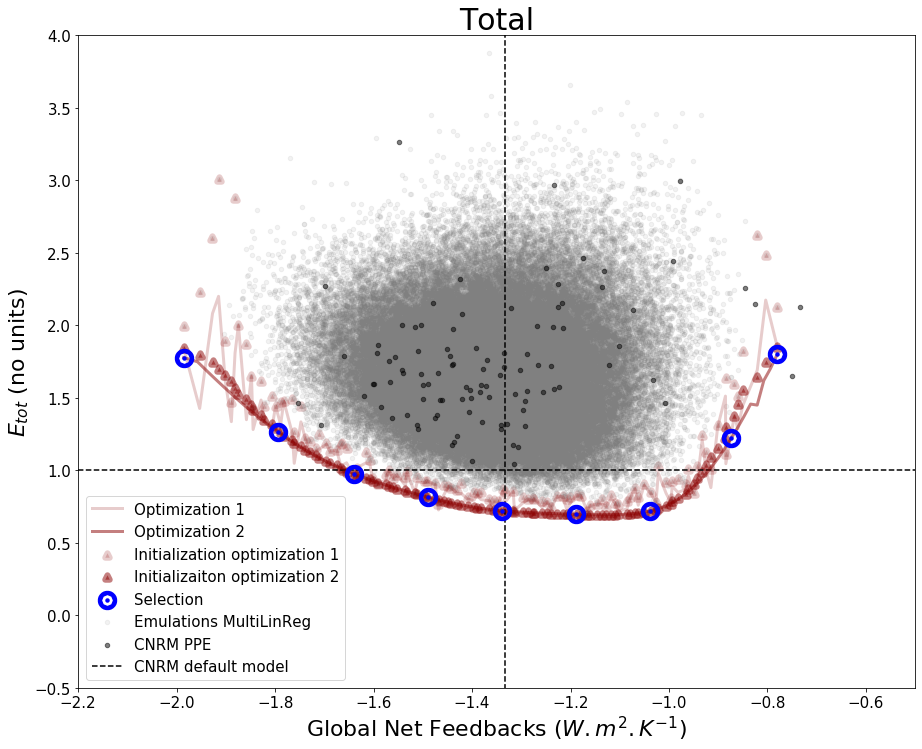

In [78]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [79]:
list_index = df_select.columns.tolist()
list_index

['sol_fun',
 'Fdbck',
 'x1_smth_0',
 'x2_smth_0',
 'x3_smth_0',
 'x4_smth_0',
 'x5_smth_0',
 'x6_smth_0',
 'x7_smth_0',
 'x8_smth_0',
 'x9_smth_0',
 'x10_smth_0',
 'x11_smth_0',
 'x12_smth_0',
 'x13_smth_0',
 'x14_smth_0',
 'x15_smth_0',
 'x16_smth_0',
 'x17_smth_0',
 'x18_smth_0',
 'x19_smth_0',
 'x20_smth_0',
 'x21_smth_0',
 'x22_smth_0',
 'x23_smth_0',
 'x24_smth_0',
 'x25_smth_0',
 'x26_smth_0',
 'x27_smth_0',
 'x28_smth_0',
 'x29_smth_0',
 'x30_smth_0']

### Save the data

In [80]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy', df_select)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select_indexes.npy', list_index)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy', sol_df_2)

In [81]:
df_select_tmp = df_select.drop(['sol_fun', 'Fdbck'], axis=1)

#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_BIS_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_TER_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_QUAT_optim2_param.txt', df_select_tmp.values)

### [Back to the top](#top)

# <a id="validation">Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3</a> </li>

### Settings

In [15]:
nb_p_list_selection = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']
len(nb_p_list_selection)

8

In [16]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([8])
df_select['sol_fun'] = df_select[0]
df_select['Fdbck'] = df_select[1]
df_select = df_select
df_select

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944,1.776953,-1.985756
1,1.261023,-1.793487,0.092451,0.775988,1.835889,16.677694,-0.095253,6.666214,4.508329,0.003164,...,0.057842,11.727646,0.000038,0.882939,0.742863,0.639256,0.586545,4.707199,1.261023,-1.793487
2,0.974675,-1.639187,0.114980,0.869206,1.792741,16.898659,-0.112145,4.443179,4.174728,0.005127,...,0.059850,8.234620,0.000054,0.863454,0.761513,0.711625,0.627510,4.275389,0.974675,-1.639187
3,0.814275,-1.489048,0.136523,1.109424,1.903055,17.453172,-0.100000,3.078862,3.825227,0.005717,...,0.055823,4.995179,0.000059,0.828581,0.718952,0.752331,0.673440,4.086714,0.814275,-1.489048
4,0.720396,-1.338640,0.150080,1.262510,1.727699,16.548401,-0.131147,2.672060,4.260765,0.004969,...,0.035107,3.799664,0.000061,0.842050,0.684948,0.758052,0.700458,4.511644,0.720396,-1.338640
5,0.694808,-1.188343,0.160636,1.537920,1.523233,12.986488,-0.175298,2.495307,4.327776,0.005232,...,0.025262,3.291661,0.000064,0.782844,0.697536,0.731226,0.732272,4.363352,0.694808,-1.188343
6,0.718234,-1.038806,0.163307,1.828007,1.512815,13.946728,-0.216507,2.336977,3.425777,0.005186,...,0.019986,2.696607,0.000062,0.678240,0.709589,0.734188,0.753012,4.404452,0.718234,-1.038806
7,1.221805,-0.873181,0.165083,2.219252,1.360215,19.891069,-0.339322,1.793060,4.713772,0.005150,...,0.015234,5.622651,0.000069,0.616350,0.623375,0.821796,0.793923,5.837056,1.221805,-0.873181


In [17]:
df_crashed = pd.DataFrame(file).drop([0,1,2,3,4,5,6,7])
df_crashed['sol_fun']=df_crashed[0]
df_crashed['Fdbck']=df_crashed[1]
df_crashed

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
8,1.798668,-0.780142,0.06,2.381172,1.107071,29.367606,-0.367773,1.81482,6.228216,0.01,...,0.01,9.162875,0.0001,0.592932,0.524065,0.926146,0.714578,7.735852,1.798668,-0.780142


In [18]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable_plot+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable_plot+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944,1.776953,-1.985756
1,1.762960,-1.971606,0.060000,0.771711,2.109585,28.387070,-0.010000,8.517878,3.179734,0.000500,...,0.042037,13.524081,0.000010,0.909729,0.629001,0.500000,0.500000,5.884610,1.762960,-1.971606
2,1.747476,-1.957607,0.064617,0.828770,2.153730,27.047637,-0.044442,8.500317,3.359057,0.000905,...,0.043889,13.598473,0.000015,0.903923,0.654323,0.520200,0.512286,5.773078,1.747476,-1.957607
3,1.701060,-1.943609,0.066933,0.817078,2.120559,25.715006,-0.049635,8.352687,3.511770,0.001104,...,0.045458,13.461733,0.000017,0.899978,0.663194,0.530337,0.518452,5.622744,1.701060,-1.943609
4,1.655735,-1.929758,0.069233,0.806180,2.088401,24.436898,-0.054642,8.205983,3.657854,0.001300,...,0.046972,13.325501,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335,1.655735,-1.929758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.455842,-0.834215,0.157016,2.346720,1.264706,23.537382,-0.364038,1.787752,5.313115,0.005856,...,0.014225,7.069913,0.000073,0.596186,0.587515,0.871901,0.797610,6.606023,1.455842,-0.834215
109,1.448764,-0.820870,0.119989,2.328477,1.221399,24.918576,-0.359082,1.792622,5.529209,0.007510,...,0.012499,7.554453,0.000084,0.600643,0.569731,0.880656,0.760203,6.873109,1.448764,-0.820870
110,1.618494,-0.807407,0.060000,2.270250,1.173089,26.355960,-0.346376,1.799802,5.749377,0.010000,...,0.010000,8.023230,0.000100,0.612746,0.548887,0.883723,0.698772,7.139820,1.618494,-0.807407
111,1.701626,-0.793798,0.060000,2.325438,1.140221,27.850900,-0.357062,1.806978,5.987342,0.010000,...,0.010000,8.589710,0.000100,0.602930,0.536530,0.904800,0.706588,7.436392,1.701626,-0.793798


### Error estimate

In [19]:
PC_PPE_selection = {}

for j in variables :
    for i in nb_p_list_selection :
        PC_PPE_selection[i+'_'+j] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+j+'.npy')
    
PC_PPE_selection

{'p840_tas': array([104.82275658,  21.36040909,  86.53868845,  17.90027052,
        -15.67627237]),
 'p841_tas': array([52.77615522, 28.2486878 , 39.60991281,  0.48478719, -5.49276356]),
 'p842_tas': array([23.3016222 , 28.7021103 , 14.50893494,  0.17227323,  3.44209364]),
 'p843_tas': array([-24.07397617,  37.99428379,   7.02245141,   1.54473352,
         11.49172786]),
 'p844_tas': array([-34.7043787 ,  19.4984308 ,   3.79652119, -12.63959083,
         20.43913611]),
 'p845_tas': array([-35.20574174,  18.17124516,  -8.88924815,  -8.60486959,
         18.35810922]),
 'p846_tas': array([-45.03254849,  18.47585924, -28.27027956,  -9.56057501,
         20.80106991]),
 'p847_tas': array([-69.72961224,  45.28096619, -57.42425643,  -1.92340307,
         12.29312962]),
 'p840_pr': array([ 19.84406816,   7.87212732, -17.94917014,   7.79871421,
         28.31608987]),
 'p841_pr': array([33.40235817, -1.7697401 , -3.23673761, 11.23597266,  5.12568096]),
 'p842_pr': array([52.30945547, -6.251585

In [20]:
E_PPE_selection = {}

for j in variables :
    list_tmp = []
    for i in nb_p_list_selection :
        pc1 = PC_PPE_selection[i+'_'+j][0]
        pc2 = PC_PPE_selection[i+'_'+j][1]
        pc3 = PC_PPE_selection[i+'_'+j][2]
        pc4 = PC_PPE_selection[i+'_'+j][3]
        pc5 = PC_PPE_selection[i+'_'+j][4]
    
        list_tmp.append(Error_emulator(pc1, pc2, pc3, pc4, pc5, j))
    E_PPE_selection[j] = list_tmp

E_PPE_selection

{'tas': [1.0970562227598584,
  0.825762087120494,
  0.7089865403554492,
  0.5878147882721297,
  0.4940098207999017,
  0.5369016165016963,
  0.5939917398278914,
  0.798450338271309],
 'pr': [0.7421351713992123,
  0.7771727717860076,
  0.7629240334698723,
  0.770651080381192,
  0.8601155702859234,
  0.8455785590339456,
  0.853169685828777,
  0.9014285471702687],
 'SW': [9.816418917293023,
  7.7845304329246545,
  5.226360483559447,
  3.473584158531328,
  1.6847386438010226,
  5.309423057413648,
  9.423108456968968,
  21.35644916728047],
 'LW': [6.3133133270922,
  6.610591001348201,
  5.50608887600766,
  5.446166279484329,
  5.540701019094109,
  5.055891396760911,
  4.935113135987308,
  7.535454966665921]}

In [21]:
E_p1_df

{'E_p1_tas': array(0.6682929),
 'E_p1_pr': array(0.5400475),
 'E_p1_SW': array(6.54059149),
 'E_p1_LW': array(3.45993611)}

In [22]:
E_PPE_selection_total=[0]*len(E_PPE_selection['tas'])

for i in range(0,len(E_PPE_selection['tas']),1) :
    E_PPE_selection_total[i] = E_PPE_selection['tas'][i]/E_p1_df['E_p1_tas']+E_PPE_selection['pr'][i]/E_p1_df['E_p1_pr']+E_PPE_selection['SW'][i]/E_p1_df['E_p1_SW']+E_PPE_selection['LW'][i]/E_p1_df['E_p1_LW']
    E_PPE_selection_total[i] = E_PPE_selection_total[i]/4

E_PPE_selection_total

[1.585329982810033,
 1.4438773743608575,
 1.2160099795214414,
 1.1029323262581325,
 1.0477120760520067,
 1.1605433519079953,
 1.3339239890843264,
 2.0767651342939075]

In [23]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/QUAT_Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.693434238433838,
 -1.7067677974700928,
 -1.6194714307785034,
 -1.5083177487055461,
 -1.4120923280715942,
 -1.1326994101206462,
 -0.8717254400253296,
 -0.5614077051480612]

# <a id="likelihood">Likelihood</a> </li>

In [24]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

CFMIP_list = ['MRI', 'CAN', 'MIROC', 'HadGEM3', 'IPSL', 'BCC']

In [25]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df

{'E_p1_tas': array(0.6682929),
 'E_p1_pr': array(0.5400475),
 'E_p1_SW': array(6.54059149),
 'E_p1_LW': array(3.45993611)}

In [26]:
Likelihood_df = pd.DataFrame()
variables = ['tas', 'pr', 'SW', 'LW']

#OSE_tmp=0
#E1_tmp = 0
#tmp1=0
#tmp2=0
#for j in variables :
#    tmp1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+j+'.npy')
#    OSE_tmp = OSE_tmp + tmp1
#
#    tmp2 = E_p1_df['E_p1_'+j]
#    E1_tmp = E1_tmp + tmp2
    
#OSE_total = OSE_tmp/len(variables)
#E_p1_df['E_p1_total'] = E1_tmp/len(variables)
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_total)


#variables = ['tas', 'pr', 'SW','LW', 'total']
RMSE_optim2={}
Fdbck_optim2={}
for i in variables :
    RMSE_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
    Fdbck_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')
    OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+i+'.npy')
    print(OSE)
    
    E_p1_tmp = E_p1_df['E_p1_'+i]
    L = []
    cpt=0
    for j in RMSE_optim2[i] :
        tmp = exp(-(j)/(2*OSE))
        tmp_2 = tmp#/(sqrt(OSE))#*1/100
        cpt+=1
        L.append(tmp_2)


    Likelihood_df['Fdbck_'+i] = Fdbck_optim2[i]
    Likelihood_df['Fdbck_likelihood_'+i] = L
    
    scale = Likelihood_df['Fdbck_likelihood_'+i].max()
    like = []
    for k in Likelihood_df['Fdbck_likelihood_'+i] : 
        tmp = k/scale
        like.append(tmp)
    Likelihood_df['Fdbck_likelihood_'+i] = like
    
#i=['total']
#tmp = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
#RMSE_optim2[i] = tmp[0]
#Fdbck_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')
#OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+i+'.npy')
    
#E_p1_tmp = E_p1['E_p1_'+i]
#L = []
#for j in RMSE_optim2[i] :
#    tmp = exp(-(j-E_p1_tmp)/(2*OSE))
#    tmp_2 = tmp/sqrt(OSE)*1/100
#    L.append(tmp_2)


#Likelihood_df['Fdbck_'+i] = Fdbck_optim2[i]
#Likelihood_df['Fdbck_likelihood_'+i] = L


#Likelihood_df['Fdbck_total'] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_total.npy')
#Likelihood_df['Fdbck_likelihood_total'] = (Likelihood_df['Fdbck_likelihood_tas']+Likelihood_df['Fdbck_likelihood_pr']+Likelihood_df['Fdbck_likelihood_SW']+Likelihood_df['Fdbck_likelihood_LW'])/4
Likelihood_df['Fdbck_likelihood_tas'][0] = Likelihood_df['Fdbck_likelihood_tas'][1]
Likelihood_df

0.08529809566785694
0.09223051648702874
2.2067994876620416
0.9267510940636671


,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW
0,-1.985856,0.172063,-1.985756,0.059617,-1.985956,0.036159,-1.985856,0.076499
1,-1.971757,0.172063,-1.971673,0.063562,-1.971752,0.042449,-1.971730,0.087260
2,-1.957710,0.172667,-1.957604,0.068311,-1.957602,0.049753,-1.957656,0.099417
3,-1.943766,0.173478,-1.943611,0.073696,-1.943557,0.058178,-1.943682,0.113054
4,-1.929972,0.174650,-1.929769,0.079292,-1.929667,0.067824,-1.929855,0.128241
...,...,...,...,...,...,...,...,...
108,-0.834152,0.217287,-0.833763,0.200684,-0.834116,0.371371,-0.834154,0.055068
109,-0.820782,0.182764,-0.820448,0.171184,-0.820770,0.337502,-0.820776,0.045650
110,-0.807271,0.155771,-0.807005,0.144461,-0.807291,0.305192,-0.807264,0.037625
111,-0.793669,0.131659,-0.793475,0.120840,-0.793721,0.274873,-0.793660,0.030869


In [27]:
i='total'
RMSE_optim2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
Fdbck_optim2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')

OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
    
E_p1_tmp = E_p1
L = []
cpt=0
for j in RMSE_optim2.transpose()[0] :
    tmp = exp(-j/(OSE))
    tmp_2 = tmp#/sqrt(OSE)*1/100
    L.append(tmp_2)
    cpt+=1


Likelihood_df['Fdbck_'+i] = Fdbck_optim2
Likelihood_df['Fdbck_likelihood_'+i] = L
Likelihood_df

,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW,Fdbck_total,Fdbck_likelihood_total
0,-1.985856,0.172063,-1.985756,0.059617,-1.985956,0.036159,-1.985856,0.076499,-1.985756,0.000507
1,-1.971757,0.172063,-1.971673,0.063562,-1.971752,0.042449,-1.971730,0.087260,-1.971606,0.000538
2,-1.957710,0.172667,-1.957604,0.068311,-1.957602,0.049753,-1.957656,0.099417,-1.957607,0.000575
3,-1.943766,0.173478,-1.943611,0.073696,-1.943557,0.058178,-1.943682,0.113054,-1.943609,0.000700
4,-1.929972,0.174650,-1.929769,0.079292,-1.929667,0.067824,-1.929855,0.128241,-1.929758,0.000850
...,...,...,...,...,...,...,...,...,...,...
108,-0.834152,0.217287,-0.833763,0.200684,-0.834116,0.371371,-0.834154,0.055068,-0.834215,0.001996
109,-0.820782,0.182764,-0.820448,0.171184,-0.820770,0.337502,-0.820776,0.045650,-0.820870,0.002057
110,-0.807271,0.155771,-0.807005,0.144461,-0.807291,0.305192,-0.807264,0.037625,-0.807407,0.000997
111,-0.793669,0.131659,-0.793475,0.120840,-0.793721,0.274873,-0.793660,0.030869,-0.793798,0.000699


In [28]:
scale = Likelihood_df['Fdbck_likelihood_total'].max()
like=[]
for i in Likelihood_df['Fdbck_likelihood_total'] :
    tmp=i/scale
    like.append(tmp)

Likelihood_df['Fdbck_likelihood_total'] = like

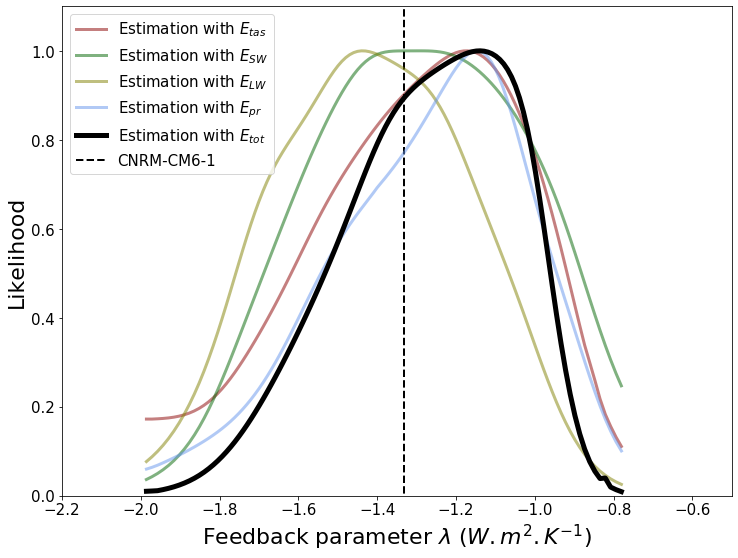

In [29]:
ax = plt.gca()



Likelihood_df.plot(kind='line', x='Fdbck_tas', y='Fdbck_likelihood_tas', color = 'darkred', 
         linewidth=3, figsize=(12, 9), alpha=0.5, ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_SW', y='Fdbck_likelihood_SW', color = 'darkgreen', 
         linewidth=3, alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_LW', y='Fdbck_likelihood_LW', color = 'olive', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_pr', y='Fdbck_likelihood_pr', color = 'cornflowerblue', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_total', y='Fdbck_likelihood_total', color = 'black', 
         linewidth=5,  ax = ax)

plt.vlines(p1_feedbacks,ymin = -1000,ymax = 1000,label='default simulation', colors='black', linewidth=2,
           linestyles='dashed')

#color_list = ['pink', 'orange', 'brown', 'green', 'gray', 'blue', 'red']
#for i in range(1, len(Fdbck_CFMIP), 1) :

#    plt.vlines(Fdbck_CFMIP[i],ymin = -1000,ymax = 1000, colors= color_list[i],  linewidth=1.0,
#           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = [ 'Estimation with $E_{tas}$', 'Estimation with $E_{SW}$', 'Estimation with $E_{LW}$', 
          'Estimation with $E_{pr}$', 'Estimation with $E_{tot}$',
                   'CNRM-CM6-1']

#for i in CFMIP_list :
#    legend.append(i)

plt.xlabel('Feedback parameter $\lambda$ ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('Likelihood', fontsize=22)
plt.legend(legend, fontsize=15)#, bbox_to_anchor=(1.35, 0.35))
#plt.title('Feedbacks likelihood', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.0,1.1)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/Feedback_likelihood.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
# now compute integral cutting right limit down by one
# with each iteration, stop as soon as we hit percplt.show()

In [30]:
# now compute integral cutting right limit down by one
# with each iteration, stop as soon as we hit perc

def my_percentile(x, y, perc):
    N = len(Likelihood_df['Fdbck_likelihood_total'])
    for k in range(1, N):
        xx = x[0:k]
        yy = y[0:k]
        v = np.trapz(yy, xx)
        v2 = (100*v)/0.63
        #print(v2)
        #print(f"Integral {k} from {xx[0]} to {xx[-1]} is equal to {v}")
        if v2 >= perc :
            tmp = x[k]
            break
    return x[k]

In [31]:
x = Likelihood_df['Fdbck_total']
y = Likelihood_df['Fdbck_likelihood_total']

perc10 = my_percentile(x,y,10)
perc50 = my_percentile(x,y,50)
perc90 = my_percentile(x,y,90)
print(perc10, perc50, perc90)

-1.549168846645013 -1.2183417566864694 -0.9217344238498258


In [32]:
ECS_perc10 = -6.517/perc10
ECS_perc50 = -6.517/perc50
ECS_perc90 = -6.517/perc90
print(ECS_perc10, ECS_perc50, ECS_perc90)

4.20677191780203 5.349073824510719 7.070366291388273


## Plot

In [51]:
cpt = 6
Lambda = Fdbck_PPE_selection[cpt]
ECS = -6.517/Lambda
ECS

7.475977757183084

In [52]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
OSE

array(0.23418511)

In [53]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_pr.npy')
OSE

array(0.09223052)

In [54]:
Fdbck_PPE_selection[7]

-0.5614077051480612

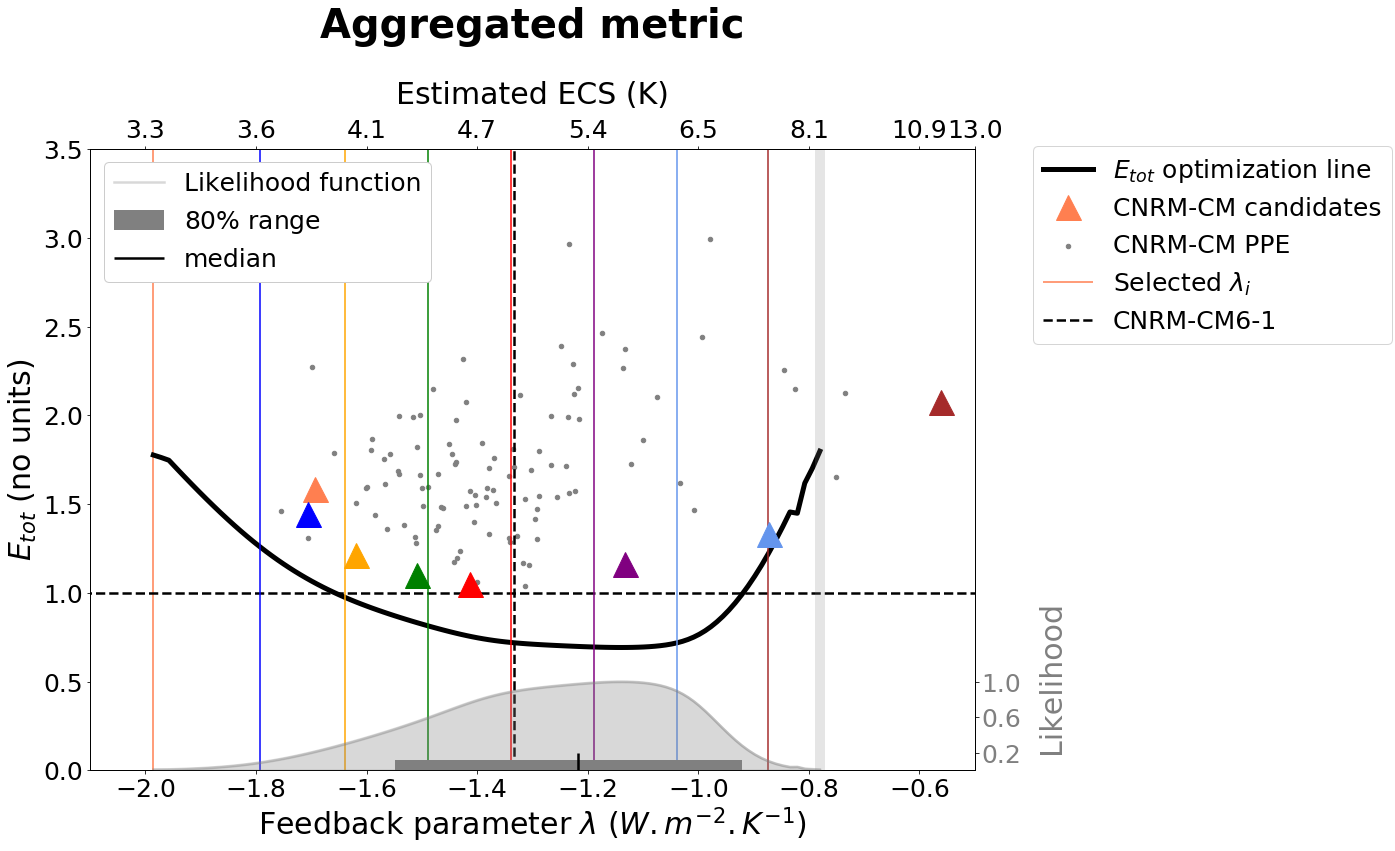

In [55]:
colors = ['coral', 'blue','orange','green','red','purple','cornflowerblue', 'brown']
cpt=0

fig = plt.figure(figsize=(15, 12))
ax = plt.gca()
ax2 = ax.twiny()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='gray', marker="o", ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)


for i in colors :
    if cpt == 0 :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)
        ax.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, label='$\lambda$ selection',
           linestyles='solid', linewidth=1.5)

        ax.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', linewidth=0, 
                        label='ARPEGE-Climat simulations', markersize=25, zorder=10)
        cpt+=1
    else :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')
        plt.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, 
           linestyles='solid', linewidth=1.5)
        
        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', 
                 linewidth=0, markersize=25, label='_nolegend_', zorder=10)
        #print(cpt)
        cpt+=1
        
plt.vlines(df_crashed['Fdbck'].iloc[0],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)
#plt.vlines(df_crashed['Fdbck'].iloc[1],ymin = -10,ymax = 25, colors='gray', 
#           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)

ax.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='ARPEGE-Climat default', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

ax.set_xlim(-2.1,-0.5)

ax3 = ax.twinx()
plt.hlines(0.0, perc10, perc90, color='gray', linestyle='solid', linewidth=20)
plt.vlines(perc50,ymin = 0.0,ymax = 0.2, colors='black', 
           linestyles='solid', linewidth=2.5)
#plt.vlines(perc90, ymin=-10, ymax=0.5, color='olive', linestyle='solid', linewidth=3.5)

       
ax.set_xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
ax.set_ylabel(ylabel, fontsize=30)
ax.set_xlim(-2.1,-0.5)
ax.set_ylim(0.0,3.5)

plt.title('Aggregated metric', fontsize=40, fontweight='bold', y=1.17)
ax.tick_params(axis='both', which='major', labelsize=25)

#plt.ylim(-0.5,3)

# Second axis

new_tick_locations = np.array([-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.5])#df_select['Fdbck'])
new_tick_locations_ax3 = np.array([ 0.2, 0.6, 1.0])

def tick_function(X):
    V = -6.517/X
    return ["%.1f" % z for z in V]

def tick_function_ax3(X):
    V=X*2
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Estimated ECS (K)", fontsize=30, labelpad=15.0)
ax2.tick_params(axis='both', which='major', labelsize=25)

ax3.set_ylim(0.0,7.0)
ax3.set_yticks(new_tick_locations_ax3)
ax3.set_yticklabels((new_tick_locations_ax3), color='gray')
ax3.set_ylabel("Likelihood", fontsize=30, position=(-0.7, 0.15), labelpad=15.0, color= 'gray')
ax3.tick_params(axis='both', which='major', labelsize=25)

Likelihood_df.plot( ax=ax3, x='Fdbck_total', y='Fdbck_likelihood_total', kind='area', linewidth=2.5,
                   color='gray', alpha=0.3)

# Legend

legend = [ '$E_{tot}$ optimization line', 'CNRM-CM candidates', 'CNRM-CM PPE', 'Selected $\lambda_i$', 
          'CNRM-CM6-1']
ax.get_legend().remove()
ax3.legend([ 'Likelihood function', '$80\%$ range', 'median'], fontsize=25, bbox_to_anchor=(0.40, 1.0), 
           facecolor='white', framealpha=1.0)
fig.legend(legend, fontsize=25, bbox_to_anchor=(1.3, 0.83)) #bbox_to_anchor=(1.05, 1)
fig.subplots_adjust(right=0.8)

plt.xlim(-2.1,-0.5)


plt.tight_layout()

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [56]:
ax.set_xlim(-2.1,-0.5)
ax.get_xlim()

(-2.1, -0.5)

In [57]:
df_RMSE_selection = pd.DataFrame(E_PPE_selection_total, columns=['E_arpege'])
df_RMSE_selection['E_multilinreg'] = df_select['sol_fun'].data

df_fdbck_selection = pd.DataFrame(Fdbck_PPE_selection, columns=['fdbck_arpege'])
df_fdbck_selection['fdbck_multilinreg'] = df_select['Fdbck'].data
df_fdbck_selection

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


,fdbck_arpege,fdbck_multilinreg
0,-1.693434,-1.985756
1,-1.706768,-1.793487
2,-1.619471,-1.639187
3,-1.508318,-1.489048
4,-1.412092,-1.338640
5,-1.132699,-1.188343
6,-0.871725,-1.038806
7,-0.561408,-0.873181


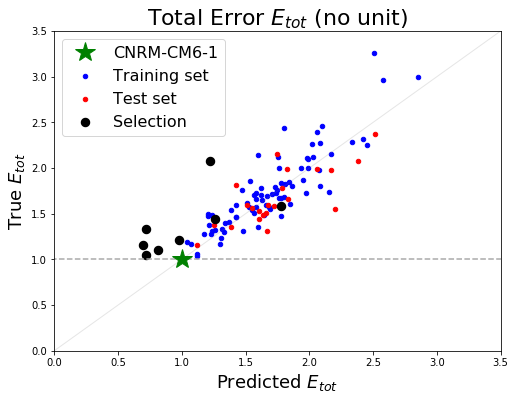

In [58]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"

Validation_RMSE_df[0:80].plot(kind='scatter', y='RMSE_PPE_total', x='RMSE_multilinreg_val_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', y='RMSE_PPE_total', x='RMSE_multilinreg_val_total', color='red',  
                     marker="o", ax = ax)

df_RMSE_selection.plot(kind='scatter', y='E_arpege', x='E_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.plot(1.0, 1.0, color='green', marker='*', 
                 linewidth=0, markersize=20, zorder=10)

ax.hlines(1.0,xmin = -10.0,xmax = 25.0,colors='darkgray', 
           linestyles='dashed', linewidth=1.5)
#ax.vlines(1.0,ymin = -10.0,ymax = 25.0,colors='black', 
#           linestyles='dashed', linewidth=2.5)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['CNRM-CM6-1', 'Training set','Test set','Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,3.5)
plt.xlim(0,3.5)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

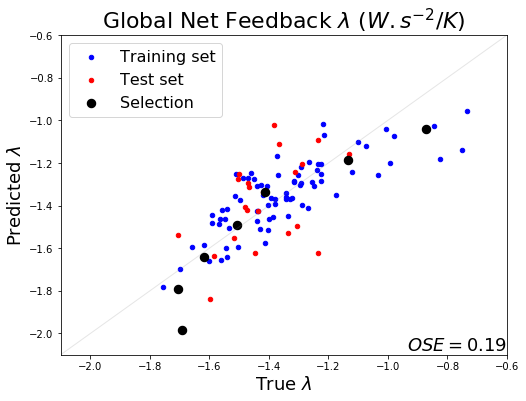

In [59]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)
df_fdbck_selection.plot(kind='scatter', x='fdbck_arpege', y='fdbck_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set', 'Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.1,-0.6)
plt.xlim(-2.1,-0.6)
ax.plot((-4.0,0.6), (-4.0,0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# <a id="param">Parameter analysis</a> </li>

In [36]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
param_names = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy')
E_emulator_df = E_multilinreg_df.reset_index()

x_emulator = pd.DataFrame(LHS, columns= param_names)
x_emulator['RMSE_total'] = E_emulator_df['RMSE_total']

x_emulator['RMSE_total_round'] = x_emulator['RMSE_total'].round(decimals=1)
x_emulator['members'] = range(0,100000,1) 

#x_emulator = x_emulator.set_index('RMSE_total_round')
#x_emulator_new_df=pd.DataFrame()
#x_emulator_new_df['RMSE_total_best'] = x_emulator['RMSE_total'].groupby('RMSE_total_round').min()
#x_emulator_new_df = x_emulator_new_df.reset_index()
#x_emulator_new_df

In [37]:
x_emulator

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE,RMSE_total,RMSE_total_round,members
0,0.237758,1.166405,0.880392,28.558061,-0.013007,5.622351,4.162592,0.003295,0.000736,0.003610,...,5.612146,0.000024,0.753132,0.692837,0.800605,0.649651,2.439231,1.128656,1.1,0
1,0.126381,0.534863,1.789610,28.480600,-0.198482,4.866094,7.643592,0.002512,0.000263,0.002387,...,18.155762,0.000076,0.655943,0.845886,0.712394,0.628513,9.773983,1.399980,1.4,1
2,0.161582,2.774511,1.700513,18.863644,-0.035909,1.940661,1.154684,0.002071,0.000726,0.007475,...,0.206254,0.000061,0.794010,0.880129,0.996989,0.713900,0.379772,1.598455,1.6,2
3,0.269570,0.617033,1.287904,21.638356,-0.425201,1.031540,7.213933,0.006568,0.000110,0.006095,...,16.561323,0.000062,0.920107,0.717110,0.717044,0.901268,9.714537,1.932700,1.9,3
4,0.152002,2.445601,1.837120,17.701181,-0.021411,9.066585,2.859292,0.001732,0.000786,0.004183,...,5.099756,0.000026,0.555454,0.882347,0.915713,0.653554,2.734065,1.304385,1.3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.153543,0.610786,2.065459,14.516229,-0.463268,8.471504,1.785016,0.003410,0.000638,0.001517,...,5.107703,0.000088,0.887371,0.829693,0.874071,0.772201,2.832374,1.590985,1.6,99995
99996,0.097080,2.208875,1.340062,10.473539,-0.304292,3.296326,1.022391,0.002612,0.000963,0.003046,...,17.028286,0.000049,0.527949,0.952927,0.519428,0.923016,2.204335,1.828308,1.8,99996
99997,0.259355,1.213350,1.786574,19.759766,-0.205054,1.078345,7.513847,0.001859,0.000531,0.009371,...,9.389115,0.000087,0.854778,0.778580,0.562029,0.586887,1.455238,1.459678,1.5,99997
99998,0.136834,1.283644,0.691964,9.627438,-0.064111,1.770910,6.090318,0.009920,0.000873,0.007538,...,19.291965,0.000057,0.823763,0.609284,0.856318,0.536784,1.115876,1.524448,1.5,99998


In [38]:
list_param = ['sol_fun', 'feedback']
for i in range(1,31,1) :
    list_param.append('x'+str(i))
#list_param

In [39]:
tmp = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
sol_df_2 = pd.DataFrame(tmp, columns=list_param)
sol_df_2

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.762960,-1.971606,0.060000,0.771711,2.109585,28.387070,-0.010000,8.517878,3.179734,0.000500,...,-2.506757,-25.984719,0.042037,13.524081,0.000010,0.909729,0.629001,0.500000,0.500000,5.884610
2,1.747476,-1.957607,0.064617,0.828770,2.153730,27.047637,-0.044442,8.500317,3.359057,0.000905,...,-2.561124,-26.715433,0.043889,13.598473,0.000015,0.903923,0.654323,0.520200,0.512286,5.773078
3,1.701060,-1.943609,0.066933,0.817078,2.120559,25.715006,-0.049635,8.352687,3.511770,0.001104,...,-2.595572,-27.401009,0.045458,13.461733,0.000017,0.899978,0.663194,0.530337,0.518452,5.622744
4,1.655735,-1.929758,0.069233,0.806180,2.088401,24.436898,-0.054642,8.205983,3.657854,0.001300,...,-2.628760,-28.054637,0.046972,13.325501,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.455842,-0.834215,0.157016,2.346720,1.264706,23.537382,-0.364038,1.787752,5.313115,0.005856,...,-2.563512,-45.052371,0.014225,7.069913,0.000073,0.596186,0.587515,0.871901,0.797610,6.606023
109,1.448764,-0.820870,0.119989,2.328477,1.221399,24.918576,-0.359082,1.792622,5.529209,0.007510,...,-2.542609,-45.587788,0.012499,7.554453,0.000084,0.600643,0.569731,0.880656,0.760203,6.873109
110,1.618494,-0.807407,0.060000,2.270250,1.173089,26.355960,-0.346376,1.799802,5.749377,0.010000,...,-2.517253,-46.132130,0.010000,8.023230,0.000100,0.612746,0.548887,0.883723,0.698772,7.139820
111,1.701626,-0.793798,0.060000,2.325438,1.140221,27.850900,-0.357062,1.806978,5.987342,0.010000,...,-2.501056,-46.721158,0.010000,8.589710,0.000100,0.602930,0.536530,0.904800,0.706588,7.436392


In [40]:
#x_init1 = pd.DataFrame(x_best, columns=[i+'_init1' for i in param_names])
#x_init1['members'] = range(0, len(x_init1), 1)
#x_init1 = x_init1.set_index('members')

#x_init1

#x_optim1 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_optim1[param_names[i]+'_optim1'] = sol_df['x'+str(j)+'_smth_0']
#x_optim1['members'] = range(0, len(x_init1), 1)
#x_optim1 = x_optim1.set_index('members')
#x_optim1

#x_init2 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_init2[param_names[i]+'_init2'] = new_sol_df['x'+str(j)+'_smth_150']
#x_init2['members'] = range(0, len(x_init1), 1)
#x_init2 = x_init2.set_index('members')
#x_init2

#x_optim2 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_optim2[param_names[i]+'_optim2'] = sol_df_2['x'+str(j)+'_smth_0']
#x_optim2['members'] = range(0, len(x_init1), 1)
#x_optim2 = x_optim2.set_index('members')
#x_optim2

#X = x_optim2 #x_init1.merge(x_optim1, on = ['members']).merge(x_init2, on = ['members']).merge(x_optim2, on = ['members'])
#X['Fdbck'] = sol_df_2['Fdbck']
#X

In [41]:
pd.options.display.float_format = '{:.5f}'.format
sol_df_2['$E_{tot}$'] = sol_df_2['sol_fun'].round(decimals=1)
test = sol_df_2
test

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,$E_{tot}$
0,1.77695,-1.98576,0.06000,0.78279,2.14205,29.77535,-0.01000,8.66446,3.02034,0.00050,...,-25.26685,0.04575,13.66146,0.00001,0.91349,0.62029,0.50000,0.50000,6.04294,1.80000
1,1.76296,-1.97161,0.06000,0.77171,2.10959,28.38707,-0.01000,8.51788,3.17973,0.00050,...,-25.98472,0.04204,13.52408,0.00001,0.90973,0.62900,0.50000,0.50000,5.88461,1.80000
2,1.74748,-1.95761,0.06462,0.82877,2.15373,27.04764,-0.04444,8.50032,3.35906,0.00091,...,-26.71543,0.04389,13.59847,0.00001,0.90392,0.65432,0.52020,0.51229,5.77308,1.70000
3,1.70106,-1.94361,0.06693,0.81708,2.12056,25.71501,-0.04964,8.35269,3.51177,0.00110,...,-27.40101,0.04546,13.46173,0.00002,0.89998,0.66319,0.53034,0.51845,5.62274,1.70000
4,1.65573,-1.92976,0.06923,0.80618,2.08840,24.43690,-0.05464,8.20598,3.65785,0.00130,...,-28.05464,0.04697,13.32550,0.00002,0.89633,0.67187,0.54041,0.52458,5.48033,1.70000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.45584,-0.83422,0.15702,2.34672,1.26471,23.53738,-0.36404,1.78775,5.31312,0.00586,...,-45.05237,0.01422,7.06991,0.00007,0.59619,0.58752,0.87190,0.79761,6.60602,1.50000
109,1.44876,-0.82087,0.11999,2.32848,1.22140,24.91858,-0.35908,1.79262,5.52921,0.00751,...,-45.58779,0.01250,7.55445,0.00008,0.60064,0.56973,0.88066,0.76020,6.87311,1.40000
110,1.61849,-0.80741,0.06000,2.27025,1.17309,26.35596,-0.34638,1.79980,5.74938,0.01000,...,-46.13213,0.01000,8.02323,0.00010,0.61275,0.54889,0.88372,0.69877,7.13982,1.60000
111,1.70163,-0.79380,0.06000,2.32544,1.14022,27.85090,-0.35706,1.80698,5.98734,0.01000,...,-46.72116,0.01000,8.58971,0.00010,0.60293,0.53653,0.90480,0.70659,7.43639,1.70000


In [68]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/QUAT_Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.693434238433838,
 -1.7067677974700928,
 -1.6194714307785034,
 -1.5083177487055461,
 -1.4120923280715942,
 -1.1326994101206462,
 -0.8717254400253296,
 -0.5614077051480612]

In [72]:
x_select = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
x_select_df = pd.DataFrame(x_select, columns = list_param).drop([8])
x_select_df['feedback_runs'] = Fdbck_PPE_selection
x_select_df

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,feedback_runs
0,1.77695,-1.98576,0.06000,0.78279,2.14205,29.77535,-0.01000,8.66446,3.02034,0.00050,...,-25.26685,0.04575,13.66146,0.00001,0.91349,0.62029,0.50000,0.50000,6.04294,-1.69343
1,1.26102,-1.79349,0.09245,0.77599,1.83589,16.67769,-0.09525,6.66621,4.50833,0.00316,...,-32.42103,0.05784,11.72765,0.00004,0.88294,0.74286,0.63926,0.58655,4.70720,-1.70677
2,0.97467,-1.63919,0.11498,0.86921,1.79274,16.89866,-0.11214,4.44318,4.17473,0.00513,...,-33.90289,0.05985,8.23462,0.00005,0.86345,0.76151,0.71163,0.62751,4.27539,-1.61947
3,0.81427,-1.48905,0.13652,1.10942,1.90306,17.45317,-0.10000,3.07886,3.82523,0.00572,...,-32.70723,0.05582,4.99518,0.00006,0.82858,0.71895,0.75233,0.67344,4.08671,-1.50832
4,0.72040,-1.33864,0.15008,1.26251,1.72770,16.54840,-0.13115,2.67206,4.26076,0.00497,...,-33.72109,0.03511,3.79966,0.00006,0.84205,0.68495,0.75805,0.70046,4.51164,-1.41209
5,0.69481,-1.18834,0.16064,1.53792,1.52323,12.98649,-0.17530,2.49531,4.32778,0.00523,...,-35.85589,0.02526,3.29166,0.00006,0.78284,0.69754,0.73123,0.73227,4.36335,-1.13270
6,0.71823,-1.03881,0.16331,1.82801,1.51282,13.94673,-0.21651,2.33698,3.42578,0.00519,...,-38.13623,0.01999,2.69661,0.00006,0.67824,0.70959,0.73419,0.75301,4.40445,-0.87173
7,1.22181,-0.87318,0.16508,2.21925,1.36021,19.89107,-0.33932,1.79306,4.71377,0.00515,...,-43.55128,0.01523,5.62265,0.00007,0.61635,0.62337,0.82180,0.79392,5.83706,-0.56141


In [124]:
r = np.corrcoef(x_select_df['feedback'], x_select_df['x1'])
r[0,1].round(decimals=2)

0.95

In [127]:
from matplotlib.axis import Axis

def plot_param(df, param_y, p1_feedback, p1_params, xlabel, ylabel, hue, colors, param_names, xlim_y, ax):
    
    colors_select = ['coral', 'blue','orange','green','red','purple','cornflowerblue', 'brown']
    
    r = np.corrcoef(x_select_df['feedback'], x_select_df[param_y])[0,1].round(decimals=2)
    
    sns.scatterplot(data=df, x="feedback", y=param_y, hue=hue, legend = 'full', 
                    palette=colors, s=100, linewidth=0, ax=ax)
    
    plt.plot(p1_feedbacks, p1_params[ylabel], color='black', marker='+', linewidth=0, markersize=50)
    
    cpt=0
    for i in colors_select :
    
        ax.plot(x_select_df['feedback_runs'][cpt], x_select_df[param_y][cpt], color=i, marker='^', 
                linewidth=0, label='_nolegend_', markersize=20, markeredgecolor='black', zorder=10)
        cpt+=1
        
    plt.text(1,0,r'$r= $'+str(r),horizontalalignment='right',
             verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
    
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel(ylabel, fontsize=22)
    #plt.legend(legend, fontsize=15)
    #plt.title('Param 1 et 2', fontsize=30)
    #ax.legend([None])

    plt.legend(markerscale=2)
    ax.get_legend().remove()
    formatter = ticker.FormatStrFormatter('%.1E')
    Axis.set_major_formatter(ax.yaxis, formatter)
    ax.tick_params(axis='both', which='major', labelsize=17)
    plt.xlim(-2.2,-0.5) 
    lim_min = xlim_y[0]-(xlim_y[1]/10)
    lim_max = xlim_y[1]+(xlim_y[1]/10)
        
    plt.ylim(lim_min,lim_max)

    # Show la figure .................
    #plt.show()

In [43]:
# READ FROM ROMAIN REF NAMELIST 

p1_params = {}
p1_params['AKN'] = 0.126
p1_params['ALPHAT'] = 1.13
p1_params['ALD'] = 1.18
p1_params['ALMAVE'] = 10.0
p1_params['AGREF'] = -0.36
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0002
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.00006
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params', p1_params)
#p1_params

In [44]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [45]:
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

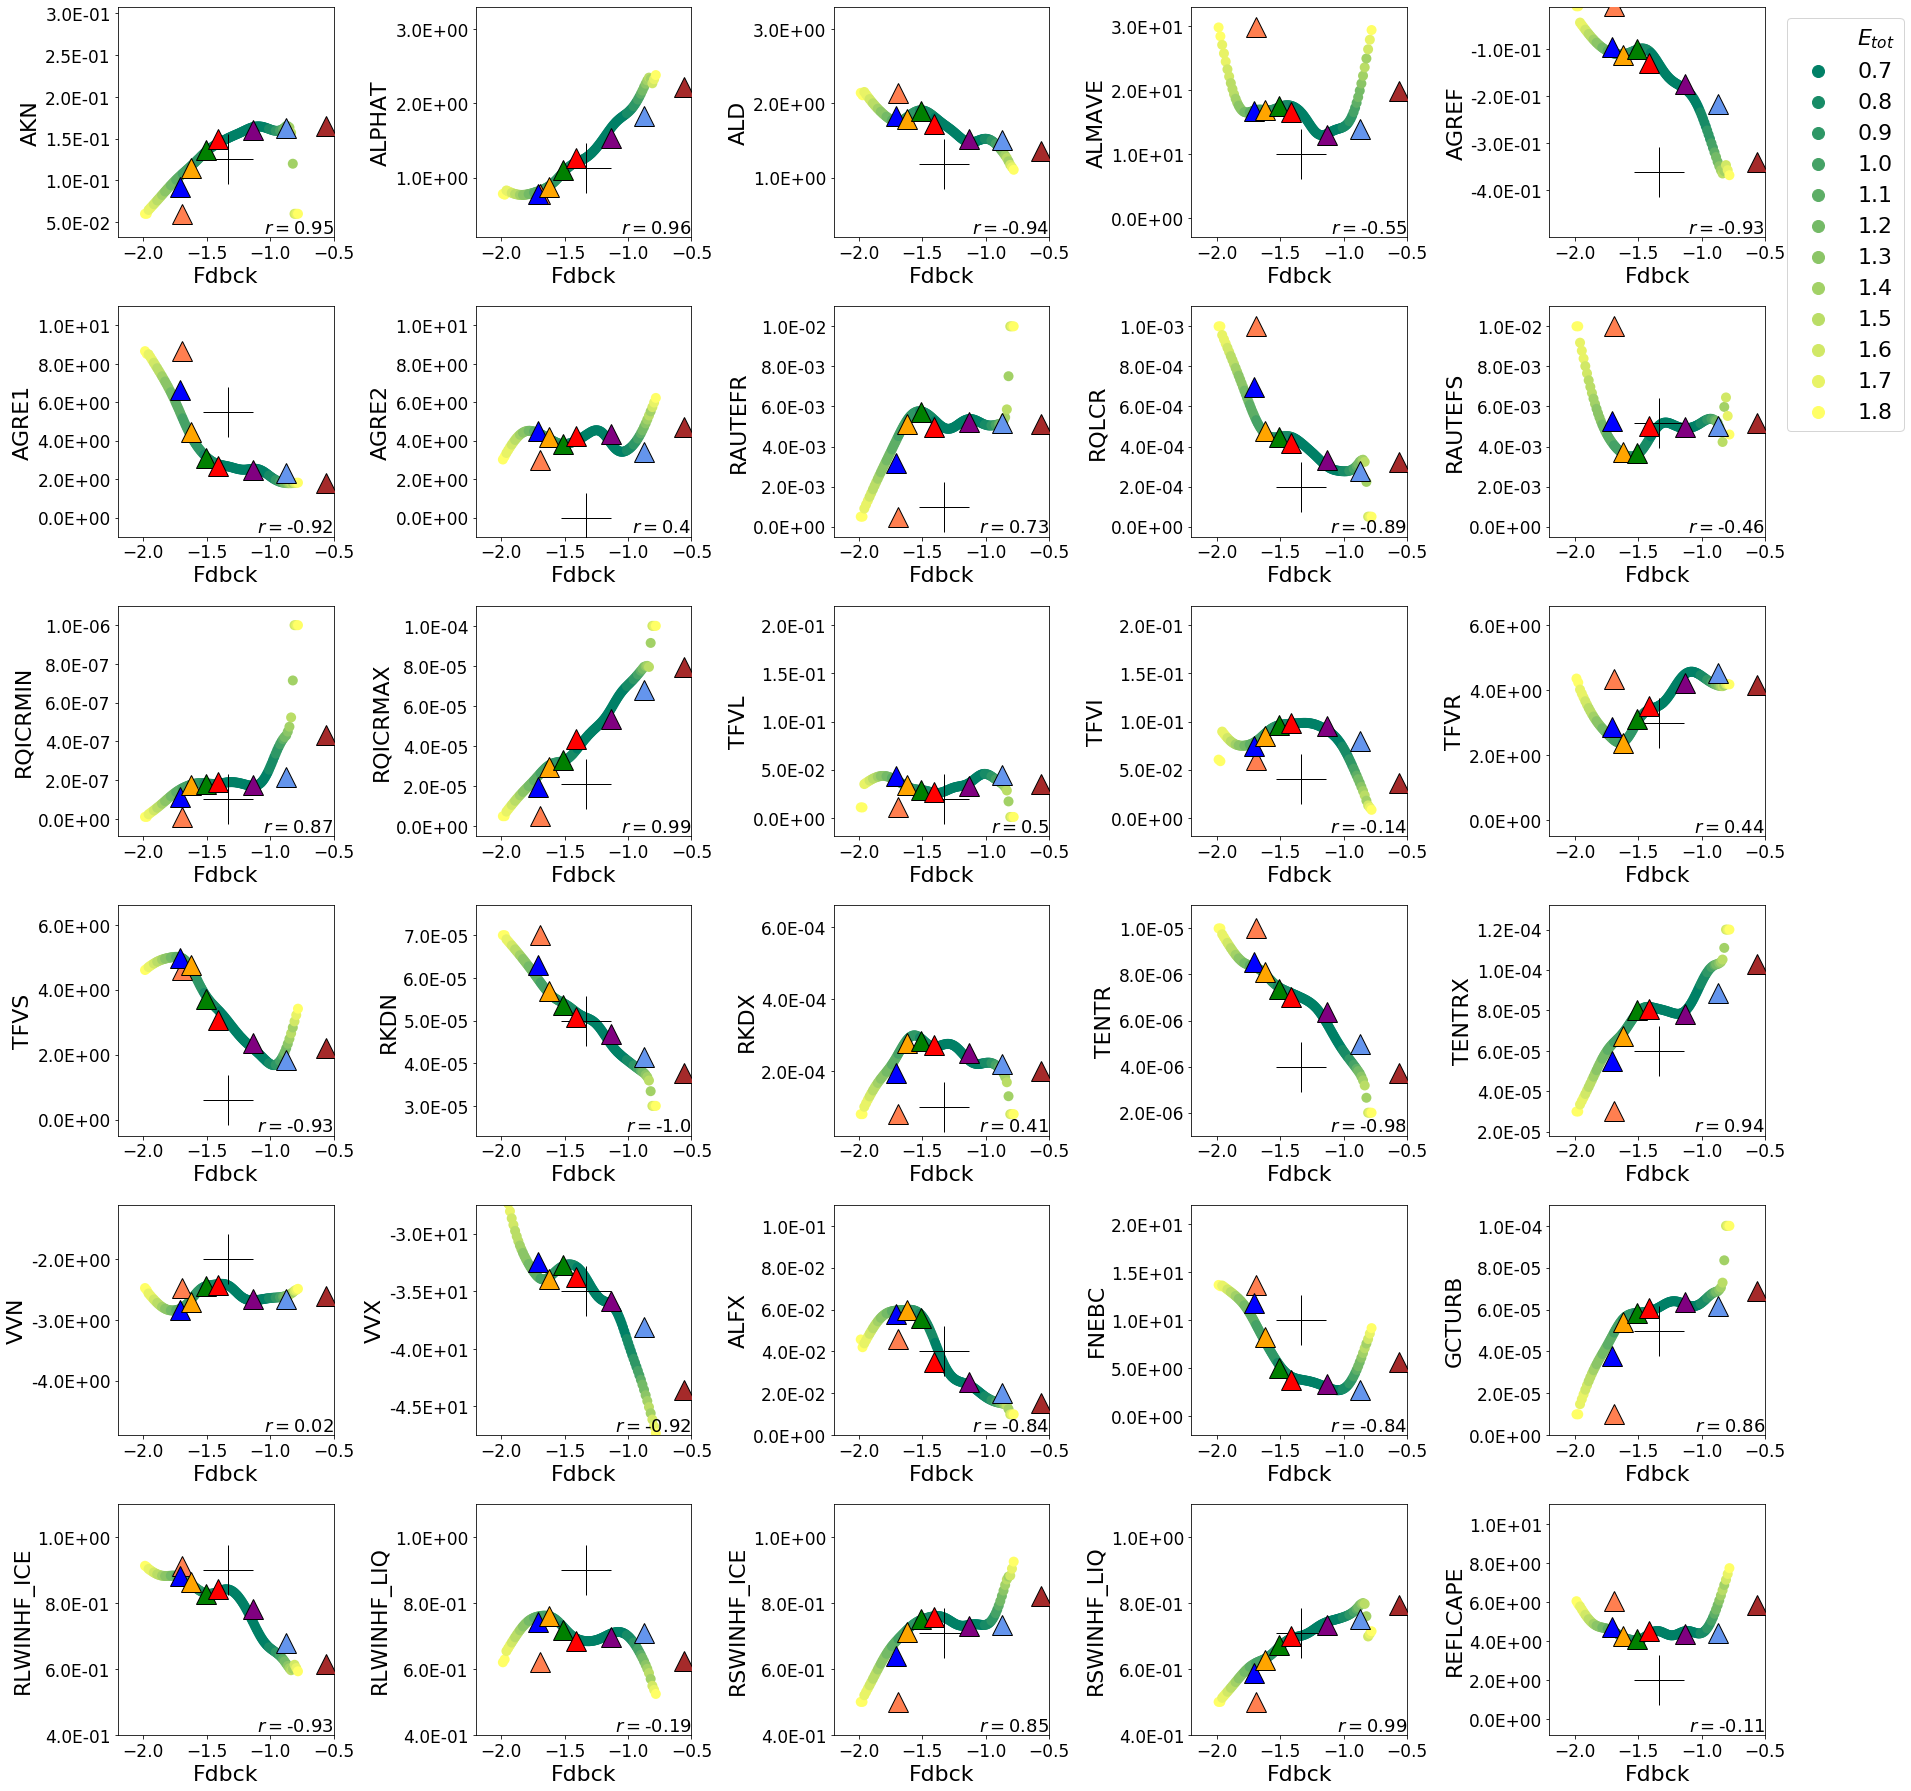

In [128]:
df=sol_df_2
hue = df['$E_{tot}$']
legend = df['$E_{tot}$']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

plt.subplots(figsize=(25,25))
ax={}

for i in range(0, 30, 1) :
    
    plt.subplot(6,5,(i+1))
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    xlim_y = xlim[i]
    plot_param(df, param_y, p1_feedbacks, p1_params, xlabel, ylabel, hue, colors, 
               param_names, xlim_y, ax[str(i)])
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 7.5), loc=2, markerscale=2)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [85]:
# FONCTIONS FEEDBACKS

def em_fdb_std_coeffs() :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs_std = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    #tmp = Coeffs.values*x
    #y_pred = tmp.sum()+R
    
    return Coeffs_std

In [100]:
Coeffs = em_fdb_std_coeffs()
Coeffs_df=pd.DataFrame(Coeffs)
Coeffs_df['abs'] = abs(Coeffs_df[0])
Coeffs_df = Coeffs_df.sort_values('abs', ascending=False)
Coeffs_df

,0,abs
ALFX,-0.07712,0.07712
TFVS,-0.04990,0.04990
ALPHAT,0.04853,0.04853
RQICRMAX,0.04766,0.04766
AKN,0.03675,0.03675
RSWINHF_LIQ,0.03520,0.03520
RKDN,-0.03411,0.03411
AGRE1,-0.03316,0.03316
RAUTEFS,-0.02392,0.02392
VVX,-0.02020,0.02020


In [93]:
param_names

0             AKN
1          ALPHAT
2             ALD
3          ALMAVE
4           AGREF
5           AGRE1
6           AGRE2
7         RAUTEFR
8           RQLCR
9         RAUTEFS
10       RQICRMIN
11       RQICRMAX
12           TFVL
13           TFVI
14           TFVR
15           TFVS
16           RKDN
17           RKDX
18          TENTR
19         TENTRX
20            VVN
21            VVX
22           ALFX
23          FNEBC
24         GCTURB
25    RLWINHF_ICE
26    RLWINHF_LIQ
27    RSWINHF_ICE
28    RSWINHF_LIQ
29       REFLCAPE
Name: 0, dtype: object

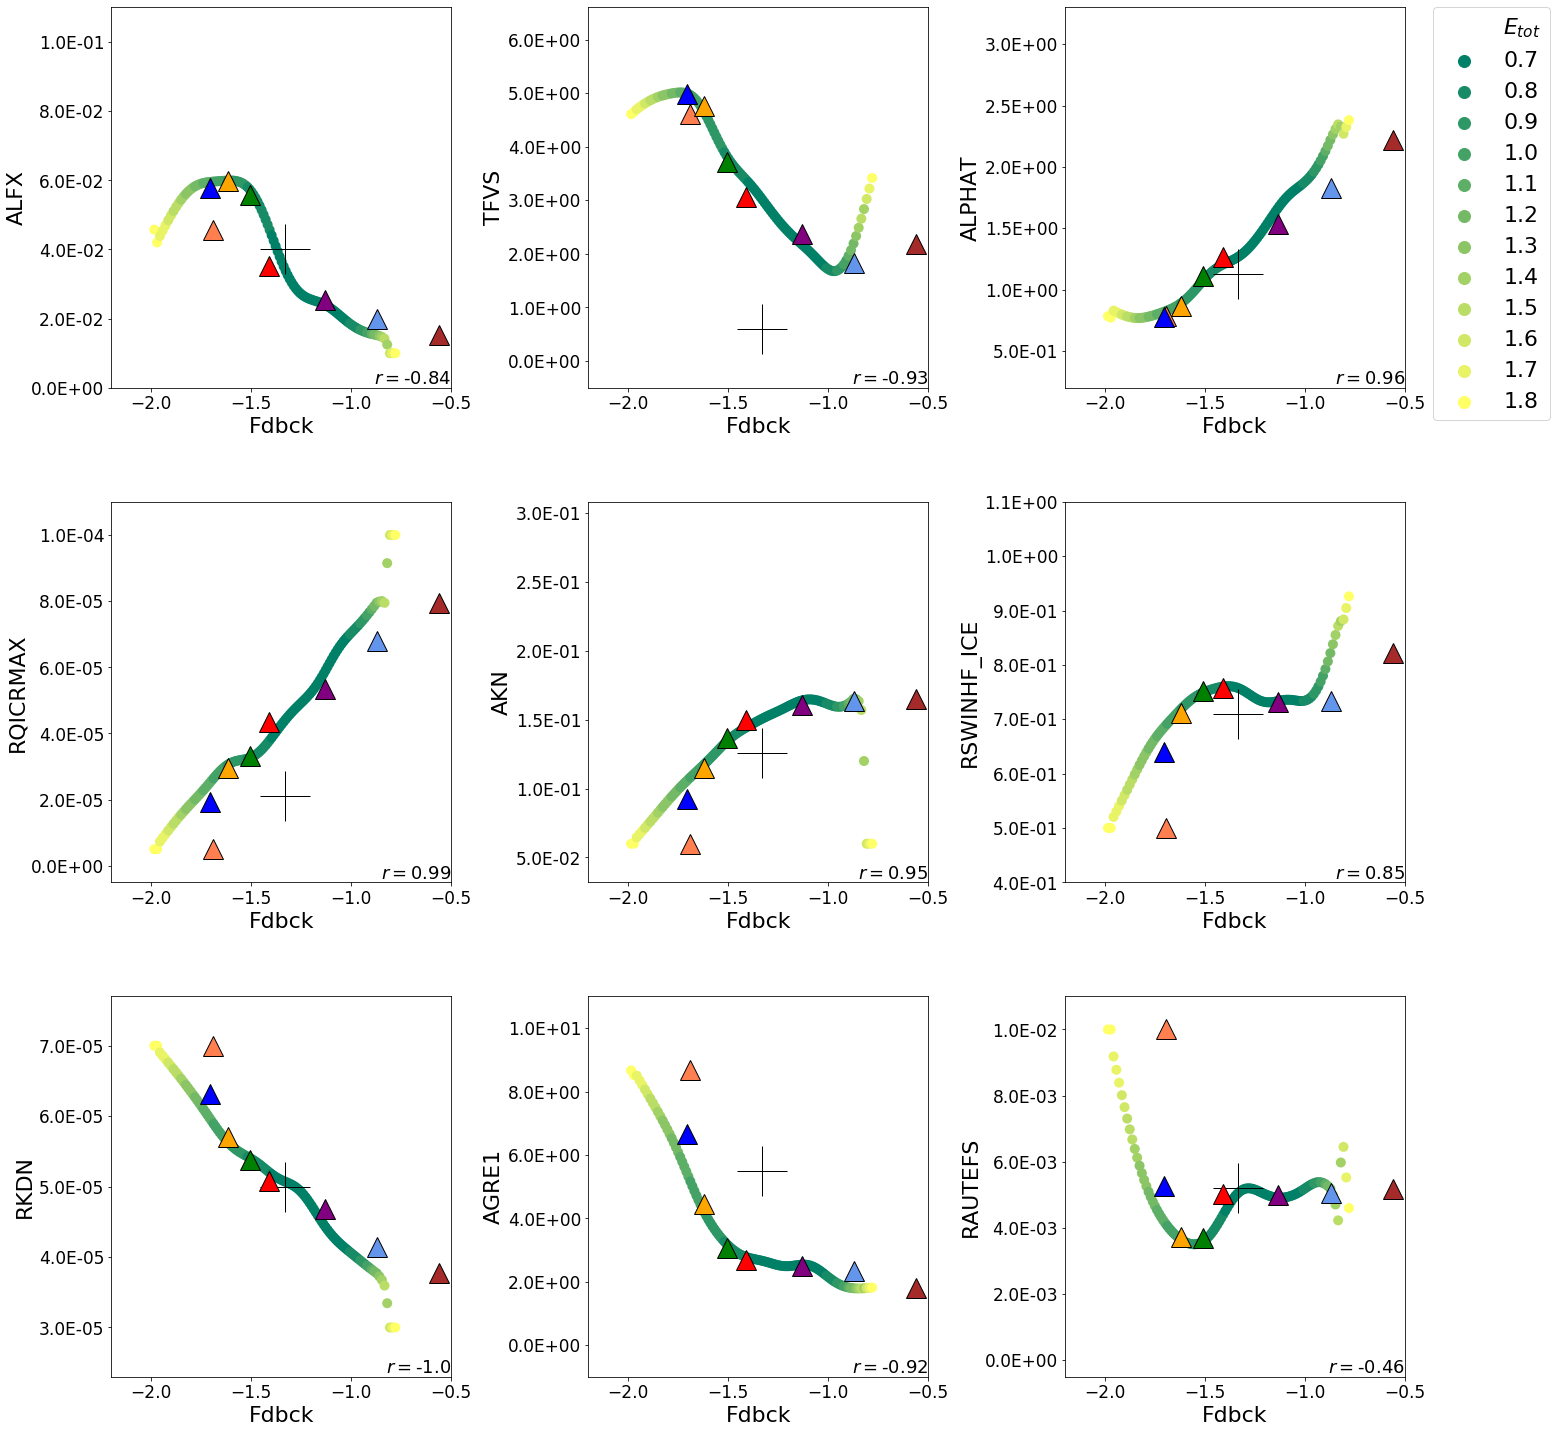

In [130]:
df=sol_df_2
hue = df['$E_{tot}$']
legend = df['$E_{tot}$']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

plt.subplots(figsize=(20,20))
ax={}

list_strong_param = [22,15,1,11,0,27,16,5,9]

cpt=1

for i in list_strong_param :
    
    plt.subplot(3,3,cpt)
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    xlim_y = xlim[i]
    plot_param(df, param_y, p1_feedbacks, p1_params, xlabel, ylabel, hue, colors, 
               param_names, xlim_y, ax[str(i)])
    cpt+=1
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 3.63), loc=2, markerscale=2) #, bbox_to_anchor=(1.05, 7.5), loc=2

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

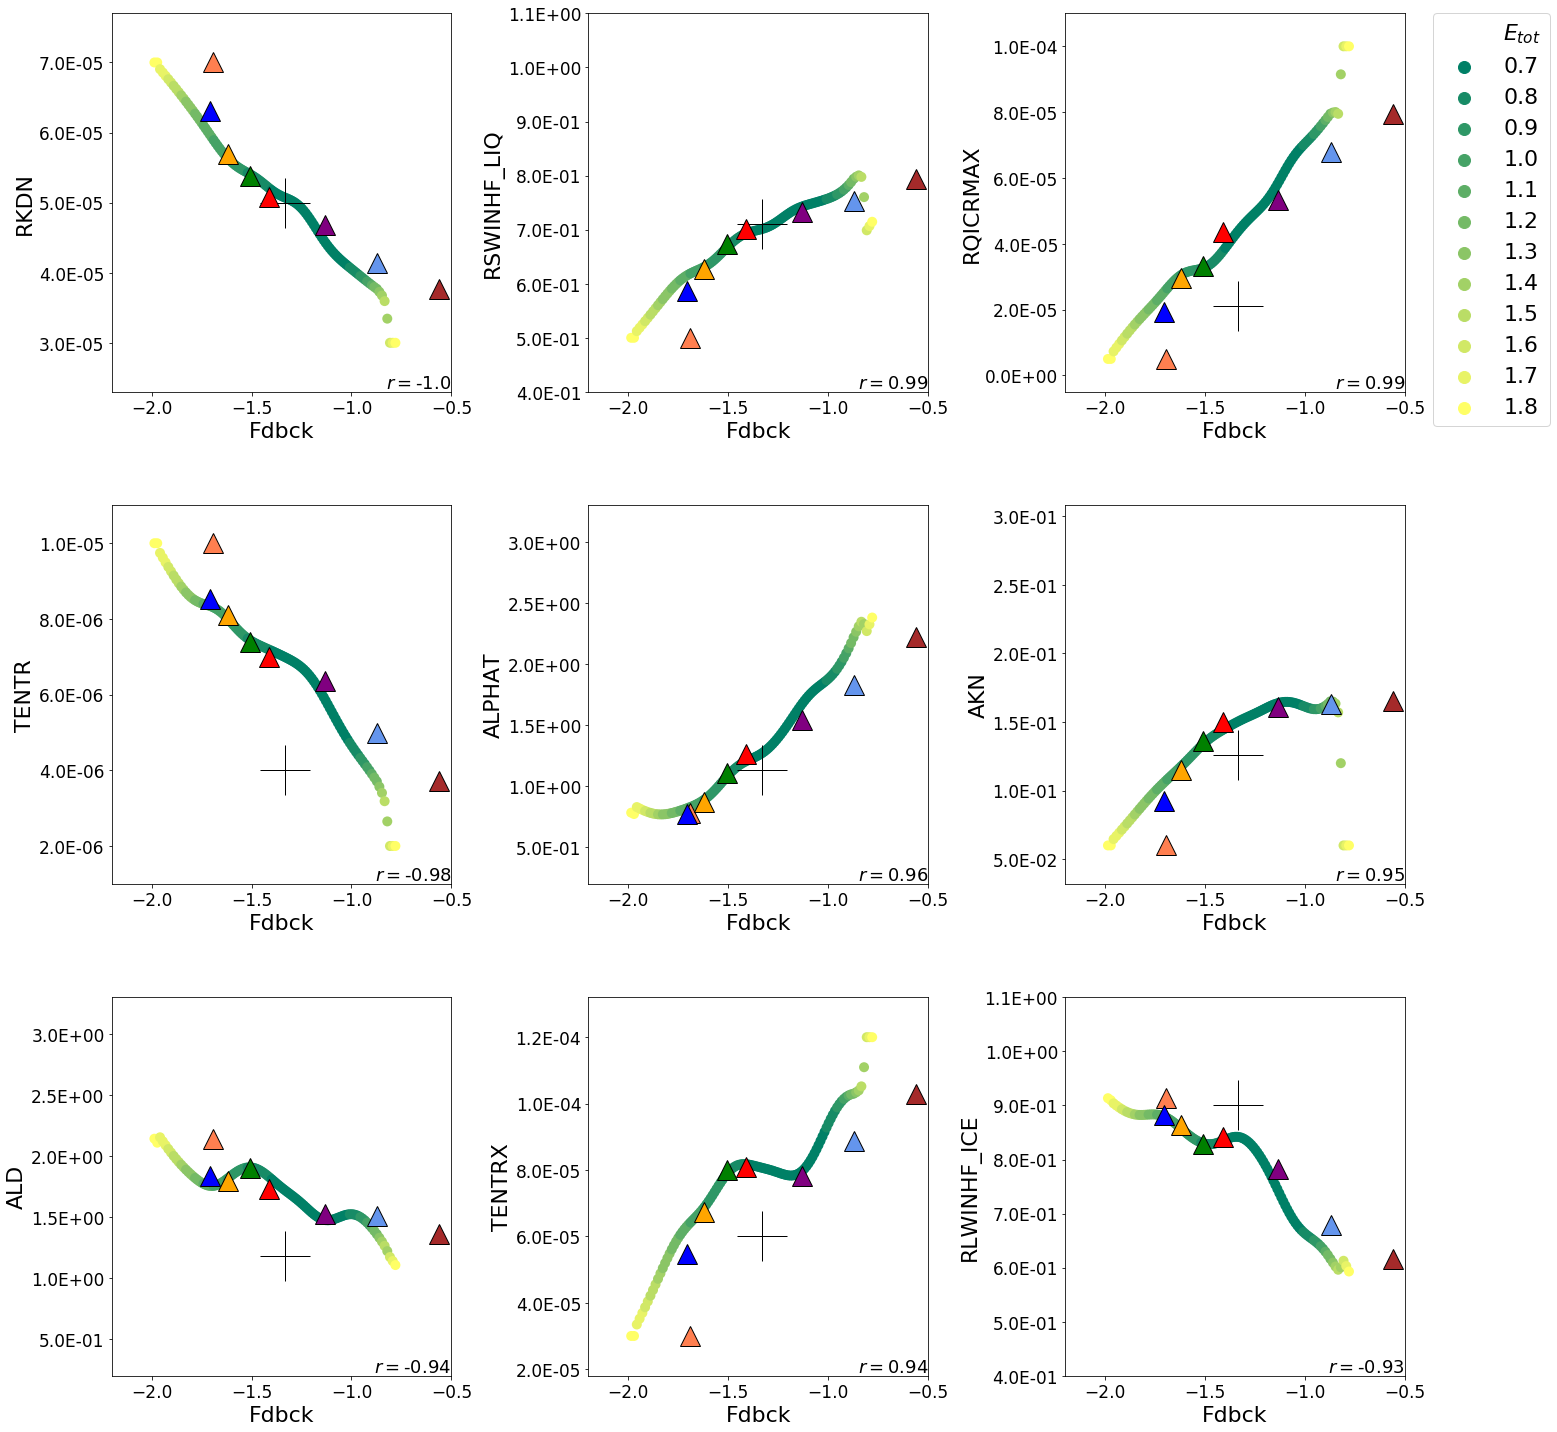

In [133]:
df=sol_df_2
hue = df['$E_{tot}$']
legend = df['$E_{tot}$']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

plt.subplots(figsize=(20,20))
ax={}

list_strong_param = [16,28,11,18,1,0, 2, 19, 25]

cpt=1

for i in list_strong_param :
    
    plt.subplot(3,3,cpt)
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    xlim_y = xlim[i]
    plot_param(df, param_y, p1_feedbacks, p1_params, xlabel, ylabel, hue, colors, 
               param_names, xlim_y, ax[str(i)])
    cpt+=1
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 3.63), loc=2, markerscale=2) #, bbox_to_anchor=(1.05, 7.5), loc=2

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()